In [8]:
library(repr) ; options(repr.plot.width = 5, repr.plot.height = 6) # Change plot sizes (in cm)

Model Fitting in Ecology and Evolution
======================================

## Introduction


In this Chapter we will work through multiple techniques of model fitting to biological data using various examples. It is recommended that you see the [lecture](https://github.com/mhasoba/TheMulQuaBio/tree/master/content/lectures/ModelFitting) on model fitting in Ecology and Evolution. 

We will use R. For starters, clear all variables and graphic devices and load necessary packages:

In [9]:
rm(list = ls())
graphics.off()

## Model fitting using Non-linear least squares

We will work with several practical examples here. These assume that you have at least a conceptual understanding of what Linear vs Non-linear models are, how they are fitted to data, and how the fits can be assessed statistically. If not, you may want to see the [Linear Models](https://github.com/vectorbite/VBiTraining2/blob/master/lectures/LinearModels) ([video here](https://drive.google.com/drive/folders/12Sj56wHX6vcAnp9GE9qQ1gIXbn7QRHU2?usp=sharing)) and [NLLS](https://github.com/mhasoba/TheMulQuaBio/blob/master/content/lectures/NLLS) lectures first.

You will need the `nls.lm` R package, which you can install using the standard method (linux users, launch R in `sudo` mode first):

```r
> install.packages("minpack.lm") 
```

```{tip}
*Why `nls.lm`*? The standard NLLS function in R, called `nls`, uses a less robust algorithm called the Gauss-Newton algorithm. Therefore, `nls` will often fail to fit your model to the data if you start off at starting values for the parameters that are too far from what the optimal values would be, especially if the "parameter space" is weirdly shaped, i.e., the model has a mathematical form that makes it hard to find parameter combinations that minimize the residual sum of squared (RSS). If this does not makes sense, don't worry about it- just go with `nls_LM` from the `nls.lm` package instead of `nls`! If you are really curious, try substituting `nls` for `nls_LM` in the examples below and compare the results.
```

Now load the `minpack.lm` package:

In [10]:
require("minpack.lm") # for Levenberg-Marquardt nlls fitting

### Traits data as an example  

Our first set of examples will focus on traits. 

A trait is any measurable feature of an individual organism. This includes physical traits (e.g., morphology, body mass, wing length), performance traits (e.g., respiration rate, body velocity, fecundity), and behavioral traits (e.g., feeding preference, foraging strategy, mate choice). All natural populations show variation in traits across individuals. A trait is functional when it directly (e.g., mortality rate) or indirectly (e.g., somatic development or growth rate) determines individual fitness. Therefore, variation in (functional) traits can generate variation in the rate of increase and persistence of populations. When measured in the context of life cycles, without considering interactions with other organisms (e.g., predators or prey of the focal population), functional traits are typically called life history traits (such as mortality rate and fecundity). Other traits determine interactions both within the focal population (e.g., intra-specific interference or mating frequency) and between the focal population/species and others, including the species which may act as resources (prey, for example). Thus both life history and interaction traits determine population fitness and therefore abundance, which ultimately influences dynamics and functioning of the wider ecosystem, such as carbon fixation rate or disease transmission rate. 

#### Allometric scaling of traits

Let's start with a common and reasonably simple example from biology: [allometric scaling](https://en.wikipedia.org/wiki/Allometry). Allometric relationships between linear measurements such as body length, wing span, and thorax width are a good way to obtain estimates of body weights of individual organisms. We will look at allometric scaling of body weight vs. total body length in dragonflies and damselfiles.   

Allometric relationships take the form:

<a id='eq:allom'></a>
$$
y = a x^b
$$

where $x$ and $y$ are morphological measures (body length and body weight respectively, in our current example), the constant is the value of $y$ at body length $x = 1$ unit, and $b$ is the scaling "exponent". This is also called a power-law, because $y$ relates to $x$ through a simple power. 

First create a function object for the power law model:

In [11]:
powMod <- function(x, a, b) {
    return(a * x^b)
}

Now get the [data](https://raw.githubusercontent.com/mhasoba/TheMulQuaBio/master/content/data/GenomeSize.csv) (first click on link and use "Save as" or `Ctrl+S` to download it as a csv). Then, save it in your `data` directory. After that, import it into your R workspace:

In [12]:
MyData <- read.csv("../data/GenomeSize.csv")

head(MyData)

,Suborder,Family,Species,GenomeSize,GenomeSE,GenomeN,BodyWeight,TotalLength,HeadLength,ThoraxLength,AdbdomenLength,ForewingLength,HindwingLength,ForewingArea,HindwingArea,MorphologyN
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Anisoptera,Aeshnidae,Aeshna canadensis,2.20,NA,1,0.159,67.58,6.83,11.81,48.94,45.47,45.40,369.57,483.61,2
2,Anisoptera,Aeshnidae,Aeshna constricta,1.76,0.06,4,0.228,71.97,6.84,10.72,54.41,46.00,45.48,411.15,517.38,3
3,Anisoptera,Aeshnidae,Aeshna eremita,1.85,NA,1,0.312,78.80,6.27,16.19,56.33,51.24,49.47,460.72,574.33,1
4,Anisoptera,Aeshnidae,Aeshna tuberculifera,1.78,0.10,2,0.218,72.44,6.62,12.53,53.29,49.84,48.82,468.74,591.42,2
5,Anisoptera,Aeshnidae,Aeshna umbrosa,2.00,NA,1,0.207,73.05,4.92,11.11,57.03,46.51,45.97,382.48,481.44,1
6,Anisoptera,Aeshnidae,Aeshna verticalis,1.59,NA,1,0.220,66.25,6.48,11.64,48.13,45.91,44.91,400.40,486.97,1


[Anisoptera](https://en.wikipedia.org/wiki/Dragonfly) are dragonflies, and [Zygoptera](https://en.wikipedia.org/wiki/Damselfly) are Damselflies. The variables of interest are `BodyWeight` and `TotalLength`.  Let's use the dragonflies data subset. 

So subset the data accordingly and remove NAs:

In [13]:
Data2Fit <- subset(MyData,Suborder == "Anisoptera")

Data2Fit <- Data2Fit[!is.na(Data2Fit$TotalLength),] # remove NA's

Plot it:

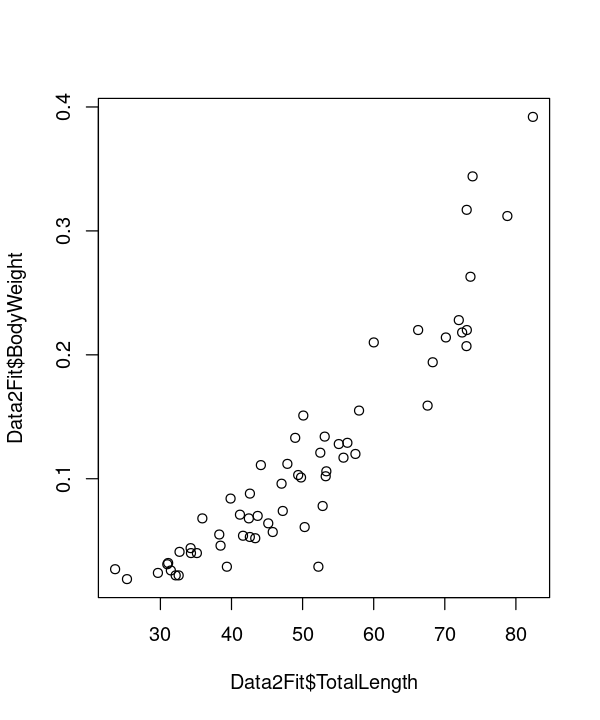

In [14]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)

Or, using `ggplot`:

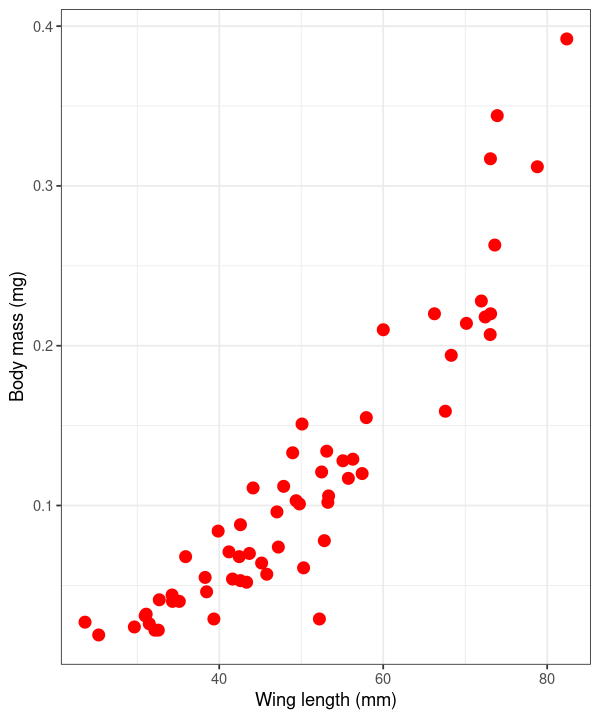

In [15]:
library("ggplot2")

ggplot(Data2Fit, aes(x = TotalLength, y = BodyWeight)) + 
geom_point(size = (3),color="red") + theme_bw() + 
labs(y="Body mass (mg)", x = "Wing length (mm)")

*Remember, when you write this analysis into a stand-alone R script, you should put all commands for loading packages (`library()`, `require()`) at the start of the script.*    

Now fit the model to the data using NLLS:

In [16]:
PowFit <- nlsLM(BodyWeight ~ powMod(TotalLength, a, b), data = Data2Fit, start = list(a = .1, b = .1))

Before proceeding further, have a look at what nlsLM's arguments are:

```rscript
?nlsLM
```

Note that NLLS fitting requires "starting values" for the parameters (two in this case: `a` and `b`). 

Having obtained the fit, we can use `summary()` just like we would for a `lm()` fit object. 

In [17]:
summary(PowFit)


Formula: BodyWeight ~ powMod(TotalLength, a, b)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 3.941e-06  2.234e-06   1.764    0.083 .  
b 2.585e+00  1.348e-01  19.174   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02807 on 58 degrees of freedom

Number of iterations to convergence: 39 
Achieved convergence tolerance: 1.49e-08


Most of the output is analogous to the output of an `lm()`. However, further statistical inference here cannot be done using Analysis of Variance (ANOVA), because the model is not a Linear Model. Try `anova(PowFit)`, and see what happens. The `Number of iterations to convergence`, and `Achieved convergence tolerance` stem from the fact that NLLS fitting requires computer simulations; revisit the [Lecture](https://github.com/mhasoba/TheMulQuaBio/blob/master/lectures/NLLS) for an explanation of this.

Now let's visualize the fit. For this, first we need to generate a vector of body lengths (the x-axis variable) for plotting: 

In [18]:
Lengths <- seq(min(Data2Fit$TotalLength),max(Data2Fit$TotalLength),len=200)

Next, calculate the predicted line. For this, we will need to extract the coefficient from the model fit object using the `coef()`command. 

In [19]:
coef(PowFit)["a"]
coef(PowFit)["b"]

a 
3.940685e-06

b 
2.585048

So, we can do the following:

In [20]:
Predic2PlotPow <- powMod(Lengths,coef(PowFit)["a"],coef(PowFit)["b"])

Now plot the data and the fitted model line:

In [21]:
Exercisesplot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)

ERROR: Error in Exercisesplot(Data2Fit$TotalLength, Data2Fit$BodyWeight): could not find function "Exercisesplot"


We can claculate the confidence intervals on the estimated parameters as we would in OLS fitting used for Linear Models: 

In [22]:
confint(PowFit)

Waiting for profiling to be done...



,2.5%,97.5%
a,1.171935e-06,1.205273e-05
b,2.318292e+00,2.872287e+00


As you likely have learnt before, a coefficient's CI should not include zero for it to be statistically significant (different from zero). 

##### Exercises <a id='Allom_Exercises'></a>

(a) Make the same plot as above, fitted line and all, in `ggplot`, and add (display) the equation you estimated to your new (ggplot) plot. The equation is: $\text{Weight} = 3.94 \times 10^{-06} \times \text{Length}^{2.59}$

(b) Try playing with the starting values, and see if you can "break" the model fitting -- that is, change the starting values till the NLLS fitting does not converge on a solution.

(c) Repeat the model fitting (including a-b above) using the Zygoptera data subset.

   
(d) There is an alternative (and in fact, more commonly-used) approach for fitting the allometric model to data: using Ordinary Least Squares on bi-logarithamically transformed data. That is, if you take a log of both sides of the [allometric equation](#eq:allom) we get,

$$
\log(y) = \log(a) + b \log(x)
$$

This is a straight line equation of the form $c = d + b z $, where $c = \log(c)$, $d = \log(a)$, $z = \log(x)$, and $b$ is now the slope parameter. So you can use Ordinary Least Squares and the linear models framework (with `lm()`) in R to estimate the parameters of the allometric equation. 

In this exercise, try comparing the NLLS vs OLS methods to see how much difference you get in the parameter estimates between them. For example, see the methods used in this paper by [Cohen et al 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3465447/).

(e) The allometry between Body weight and Length is not the end of the story. You have a number of other linear morphological measurements (`HeadLength`, `ThoraxLength`, `AdbdomenLength`, `ForewingLength`, `HindwingLength`, `ForewingArea`, and `HindwingArea`) that can also be investigated. In this exercise, try two lines of investigation (again, repeated separately for Dragonflies and Damselfiles): 

  (i) How do each of these measures allometrically scale with Body length (obtain estimates of scaling constant and exponent)? (Hint: you may want to use the `pairs()` command in R to get an overview of all the pairs of potential scaling relationships. 

  (ii) Do any of the linear morphological measurements other than body length better predict Body weight? That is, does body weight scale more tightly with a linear morphological measurement other than total body length? You would use model selection here, which we will learn next. But for now, you can just look at and compare the $R^2$ values of the models.

(Model-Fitting-R-Comparing-Models)=
#### Comparing models

*How do we know that there isn't a better or alternative model that adequately explains the pattern in your dataset?* 

This is important consideration in all data analyses (and more generally, the scientific method!), so you must aim to compare your NLLS model with an one or more alternatives for a more extensive and reliable investigation of the problem. 

Let's use  model comparison to investigate whether the relationship between body weight and length we found above is indeed allometric. For this, we need an alternative model that can be fitted to the same data. Let's try a quadratic curve, which is of the form:

$$
y = a + b x + c x^2
$$

This can also capture curvature in data, and is an alternative model to the [allometric equation](#eq:allom). Note that this mode is linear in its parameters (a linear model), which you can fit to the simply data using your familiar `lm()` function: 

In [23]:
QuaFit <- lm(BodyWeight ~ poly(TotalLength,2), data = Data2Fit)

And like before, we obtain the predicted values (but this time using the `predict.lm` function):

In [24]:
Predic2PlotQua <- predict.lm(QuaFit, data.frame(TotalLength = Lengths))

Now let's plot the two fitted models together:

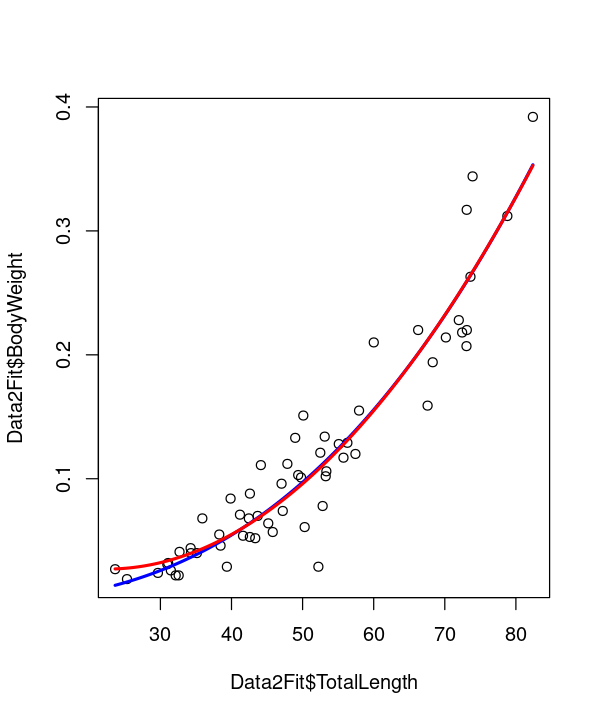

In [25]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)
lines(Lengths, Predic2PlotQua, col = 'red', lwd = 2.5)

Very similar fits, except that the quadratic model seems to deviate a bit from the data at the lower end of the data range. Let's do a proper, formal model comparison now to check which model better-fits the data.

First calculate the R$^2$ values of the two fitted models:

In [26]:
RSS_Pow <- sum(residuals(PowFit)^2)  # Residual sum of squares
TSS_Pow <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2)  # Total sum of squares
RSq_Pow <- 1 - (RSS_Pow/TSS_Pow)  # R-squared value

RSS_Qua <- sum(residuals(QuaFit)^2)  # Residual sum of squares
TSS_Qua <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2)  # Total sum of squares
RSq_Qua <- 1 - (RSS_Qua/TSS_Qua)  # R-squared value

RSq_Pow 
RSq_Qua

[1] 0.9005475

[1] 0.9003029

Not very useful. In general, R$^2$ is a good measure of model fit, but cannot be used for model selection -- epecially not here, given the tiny difference in R$^2$'s.

Instead, as explained in the [lecture](https://github.com/mhasoba/TheMulQuaBio/blob/master/lectures/ModelFitting), we can use the Akaike Information Criterion (AIC):

In [27]:
n <- nrow(Data2Fit) #set sample size
pPow <- length(coef(PowFit)) # get number of parameters in power law model
pQua <- length(coef(QuaFit)) # get number of parameters in quadratic model

AIC_Pow <- n + 2 + n * log((2 * pi) / n) +  n * log(RSS_Pow) + 2 * pPow
AIC_Qua <- n + 2 + n * log((2 * pi) / n) + n * log(RSS_Qua) + 2 * pQua
AIC_Pow - AIC_Qua

[1] -2.147426

Of course, as you might have suspected, we can do this using an in-built function in R! 

In [28]:
AIC(PowFit) - AIC(QuaFit)

[1] -2.147426

*So which model wins?* As we had dicussed in the NLLS lecture, a rule of thumb is that a AIC value difference (typically denoted as $\Delta$AIC) > 2 is a acceptable cutoff for calling a winner. So the power law (allometric model) is a better fit here. Read the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/readings/Modelling/JohnsonOmland2004.pdf) for more on model selection in Ecology and Evolution.    

#### Exercises <a id='ModelSelection_Exercises'></a>

(a) Calculate the Bayesian Information Criterion (BIC), also know as the Schwarz Criterion (see your Lecture notes and the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/readings/Modelling/JohnsonOmland2004.pdf), and use $\Delta$BIC to select the better fitting model. 

(b) Fit a straight line to the same data and compare with the allometric and quadratic models.

(c) Repeat the model comparison (incuding 1-2 above) using the Damselflies (Zygoptera) data subset -- does the allometric model still win?

(d) Repeat exercise (e)(i) and (ii) from the [above set](#Allom_Exercises), but with model comparison (e.g., again using a quadratic as an alternative model) to establish that the relationships are indeed allometric.

(e) Repeat exercise (e)(ii) from the [above set](#Allom_Exercises), but with model comparison to establish which linear measurement is the best predictor of Body weight.

#### Albatross chick growth

Now let's look at a different trait example: the growth of an individual albatross chick (you can find similar data for vector and non-vector arthropods in [VecTraits](https://vectorbyte.org/)). First load and plot the data:

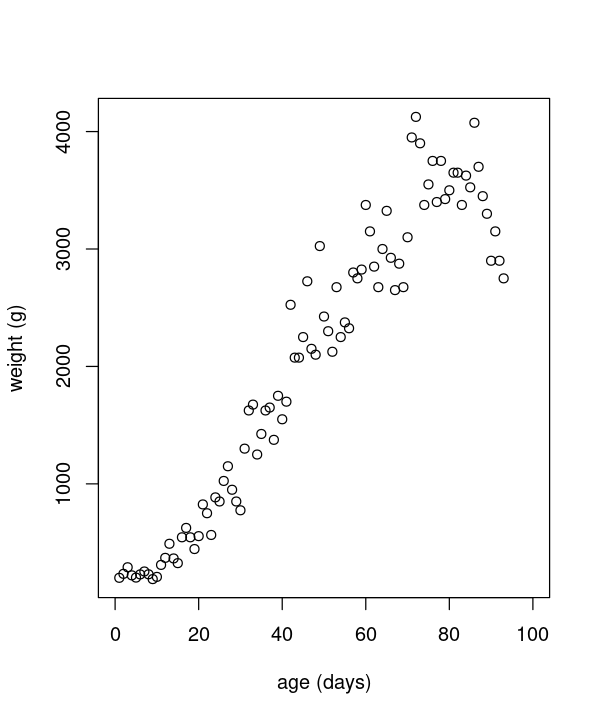

In [29]:
alb <- read.csv(file="../data/albatross_grow.csv")
alb <- subset(x=alb, !is.na(alb$wt))
plot(alb$age, alb$wt, xlab="age (days)", ylab="weight (g)", xlim=c(0, 100))

##### Fitting the three models using NLLS

Let's fit multiple models to this dataset.

The Von Bertalanffy model is commonly used for modelling the growth of an individual. It's formulation is:

$$
W(t) = \rho (L_{\infty}(1-e^{-Kt})+L_0 e^{-Kt})^3
$$

If we pull out $L_{\infty}$ and define $c=L_0/L_{\infty}$ and $W_{\infty}=\rho L_{\infty}^3$ this equation becomes:

$$
W(t) = W_{\infty}(1-e^{-Kt}+ c e^{-Kt})^3.
$$

$W_{\infty}$ is interpreted as the mean asymptotic weight, and $c$ the ratio between the initial and final lengths. This second equation is the one we will fit.

We will compare this model against the classical Logistic growth equation and a straight line.

The logistic equation is:

$$
N_t =   \frac{N_0  K e^{r t}}{K + N_0 (e^{r t} - 1)}
$$

Here $N_t$ is population size at time $t$, $N_0$ is initial population size, $r$ is maximum growth rate (AKA $r_\text{max}$), and $K$ is carrying capacity.


 First, as we did before, let's define the R functions for the two models:

In [30]:
logistic1<-function(t, r, K, N0){
  N0*K*exp(r*t)/(K+N0*(exp(r*t)-1))
}

vonbert.w<-function(t, Winf, c, K){
  Winf*(1 - exp(-K*t) + c*exp(-K*t))^3
}

For the straight line, we use simply use R's `lm()` function, as that is a linear least squares problem. Using NLLS will give (approximately) the same answer, of course. Now fit all 3 models using least squares. 

We will scale the data before fitting to improve the stability of the estimates:

In [31]:
scale<-4000

alb.lin<-lm(wt/scale~age, data=alb)

In [32]:
alb.log<-nlsLM(wt/scale~logistic1(age, r, K, N0), start=list(K=1, r=0.1, N0=0.1), data=alb)

alb.vb<-nlsLM(wt/scale~vonbert.w(age, Winf, c, K), start=list(Winf=0.75, c=0.01, K=0.01), data=alb)

Next let's calculate predictions for each of the models across a range of ages.

In [33]:
ages<-seq(0, 100, length=1000)

pred.lin<-predict(alb.lin, newdata = list(age=ages))*scale

pred.log<-predict(alb.log, newdata = list(age=ages))*scale

pred.vb<-predict(alb.vb, newdata = list(age=ages))*scale

And finally plot the data with the fits:

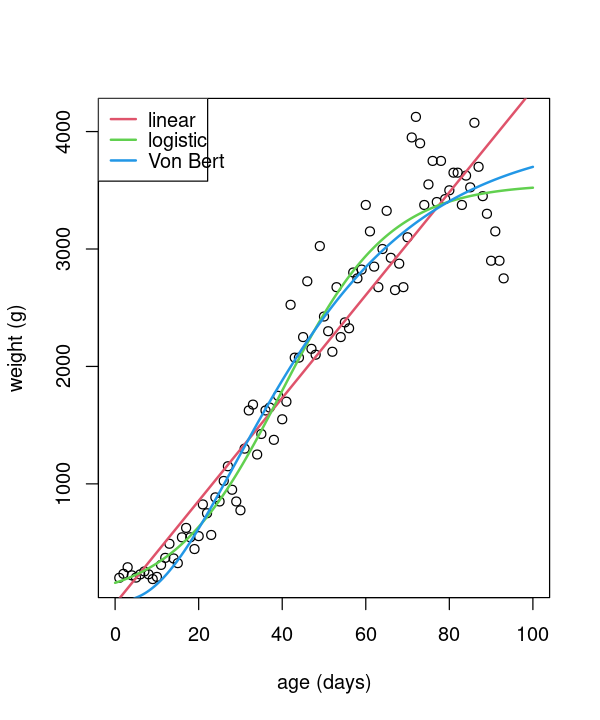

In [34]:
plot(alb$age, alb$wt, xlab="age (days)", ylab="weight (g)", xlim=c(0,100))
lines(ages, pred.lin, col=2, lwd=2)
lines(ages, pred.log, col=3, lwd=2)
lines(ages, pred.vb, col=4, lwd=2)

legend("topleft", legend = c("linear", "logistic", "Von Bert"), lwd=2, lty=1, col=2:4)

Next examine the residuals between the 3 models:

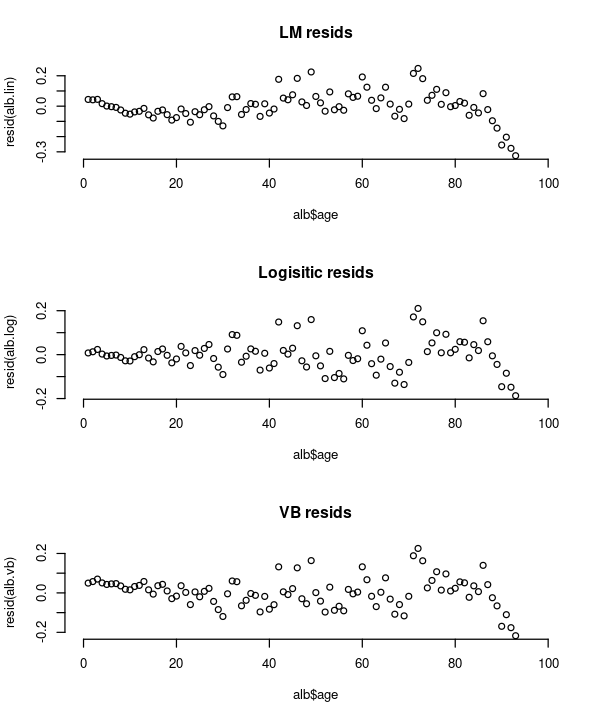

In [35]:
par(mfrow=c(3,1), bty="n")
plot(alb$age, resid(alb.lin), main="LM resids", xlim=c(0,100))
plot(alb$age, resid(alb.log), main="Logisitic resids", xlim=c(0,100))
plot(alb$age, resid(alb.vb), main="VB resids", xlim=c(0,100))

The residuals for all 3 models still exhibit some patterns. In particular, the data seems to go down near the end of the observation period, but none of these models can capture that behavior. 

Finally, let's compare the 3 models using a simpler approach than the AIC/BIC one that  we used [above](#Allom_Exercises) by calculating adjusted Sums of Squared Errors (SSE's):

In [36]:
n<-length(alb$wt)
list(lin=signif(sum(resid(alb.lin)^2)/(n-2 * 2), 3), 
    log= signif(sum(resid(alb.log)^2)/(n-2 * 3), 3), 
    vb= signif(sum(resid(alb.vb)^2)/(n-2 * 3), 3))          

$lin
[1] 0.00958

$log
[1] 0.0056

$vb
[1] 0.00628

The adjusted SSE accounts for sample size and number of parameters by dividing the RSS by the residual degrees of freedom. Adjusted SSE can also be used for model selection like AIC/BIC (but is less robust than AIC/BIC). The residual degrees of freedom is calculated as the number of response values (sample size, $n$) minus 2, times the number of fitted coefficients $m$ (= 2 or 3 in this case) estimated.

The logistic model has the lowest adjusted SSE, so it's the best by this measure. It is also, visually, a better fit. 

#### Exercises <a id='Albatross_Exercises'></a>

(a) Use AIC/BIC to perform model selection on the Albatross data as we did for the trait allometry example.

(b) Write this example as a self-sufficient R script, with ggplot istead of base plotting 

#### Aedes aegypti fecundity

Now let's actually look at a disease vector example. These data measure the reponse of *Aedes aegypti* fecundity to temperature. 

First load and visualize the data:

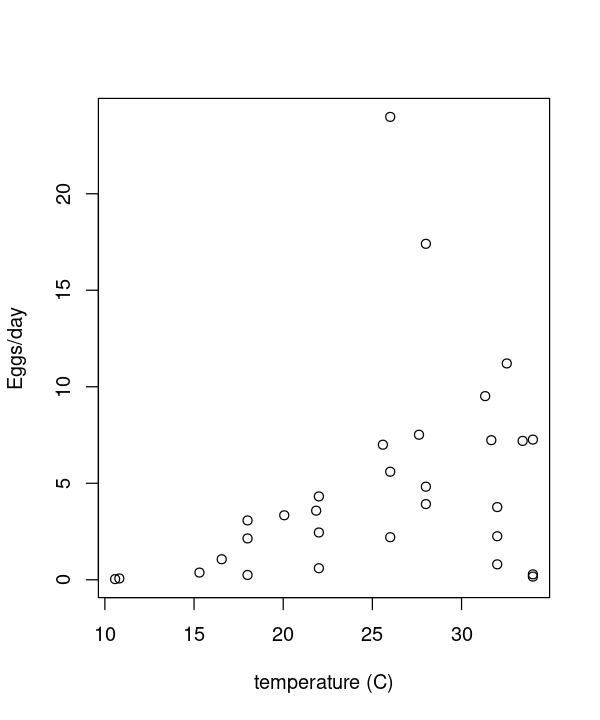

In [37]:
aedes<-read.csv(file="../data/aedes_fecund.csv")

plot(aedes$T, aedes$EFD, xlab="temperature (C)", ylab="Eggs/day")

##### The TPC models

Let's define some models first:

In [38]:
quad1 <- function(T, T0, Tm, c){
  c*(T-T0)*(T-Tm)*as.numeric(T<Tm)*as.numeric(T>T0)
}

briere <- function(T, T0, Tm, c){
  c*T*(T-T0)*(abs(Tm-T)^(1/2))*as.numeric(T<Tm)*as.numeric(T>T0)
}

Instead of using the inbuilt quadratic function in R, we we define our own to make it easier to choose starting values, and so that we can force the function to be equal to zero above and below the minimum and maximum temperature thresholds (more on this below). The Briere function is a commonly used model for tempoeratuire dependence of insect traits. As in the case of the albatross growth data, we will also compare these two with a strauight line (again, its a linear model, so we can just use `lm()` without needing to define a function for it). 

Now fit all 3 models using least squares. Although it's not as necessary here (as the data don't have as large values as the albatross example), we will again scale the data first: 

In [39]:
scale <- 20

aed.lin <- lm(EFD/scale~T, data=aedes)

aed.quad <- nlsLM(EFD/scale~quad1(T, T0, Tm, c), start=list(T0=10, Tm=40, c=0.01), data=aedes)

aed.br <- nlsLM(EFD/scale~briere(T, T0, Tm, c), start=list(T0=10, Tm=40, c=0.1), data=aedes)

##### Exercises <a id='Aedes_Exercises'></a>

(a) Complete the *Aedes* data analysis by fitiing model, calculating predictions and then comparing models. Write a single, self-standing script for it. Which model fits best? By what measure?

(b) In this script, use ggplot instead of base plotting.

### Abundances as an example

Fluctuations in the abundance (density) of single populations may play a crucial role in ecosystem dynamics and emergent functional characteristics, such as rates of carbon fixation or disease transmission. For example, if vector population densities or their traits change at the same or shorter timescales than the rate of disease transmission, then (vector) abundance fluctuations can cause significant fluctuations in disease transmission rates. Indeed, most disease vectors are small ectotherms with short generation times and greater sensitivity to environmental conditions than their (invariably larger, longer-lived, and often, endothermic) hosts. So understanding how populations vary over time, space, and with respect to environmental variables such as temperature and precipitation is key. We will look at fitting models to the growth of a single population here. 

(Model-Fitting-R-Population-Growth)=
#### Population growth rates

A population grows exponentially while its abundance is low and resources are not limiting (the Malthusian principle). This growth then slows and eventually stops as resources become limiting. There may also be a time lag before the population growth really takes off at the start. We will focus on microbial (specifically, bacterial) growth rates. Bacterial growth in batch culture follows a distinct set of phases; lag phase, exponential phase and stationary phase. During the lag phase a suite of transcriptional machinery is activated, including genes involved in nutrient uptake and metabolic changes, as bacteria prepare for growth. During the exponential growth phase, bacteria divide at a constant rate, the population doubling with each generation. When the carrying capacity of the media is reached, growth slows and the number of cells in the culture stabilizes, beginning the stationary phase. 

Traditionally, microbial growth rates were measured by plotting cell numbers or culture density against time on a semi-log graph and fitting a straight line through the exponential growth phase &ndash; the slope of the line gives the maximum growth rate ($r_{max}$). Models have since been developed which we can use to describe the whole sigmoidal bacterial growth curve (e.g., using NLLS). Here we will take a look at these different approaches, from applying linear models to the exponential phase, through to fitting non-linear models to the full growth curve.

Let's first generate some "data" on the number of bacterial cells as a function of time that we can play with:

In [40]:
t <- seq(0, 22, 2)
N <- c(32500, 33000, 38000, 105000, 445000, 1430000, 3020000, 4720000, 5670000, 5870000, 5930000, 5940000)

set.seed(1234) # set seed to ensure you always get the same random sequence  

data <- data.frame(t, N * (1 + rnorm(length(t), sd = 0.1))) # add some random error

names(data) <- c("Time", "N")

head(data)

,Time,N
,<dbl>,<dbl>
1,0,28577.04
2,2,33915.52
3,4,42120.88
4,6,80370.17
5,8,464096.05
6,10,1502365.99


Note how we added some random "sampling" error using `N * (1 + rnorm(length(t), sd = .1))`. 

This means that we are adding an error at each time point $t$ (let's call this fluctuation $\epsilon_t$) as a *percentage* of the population ($N_t$) at that time point in a vectorized way. That is, we are performing the operation $N_t \times (1 + \epsilon_t)$ at all time points at one go. This is important to note because this is often the way that errors appear &ndash; proportional to the value being measured.

Now let's plot these data:

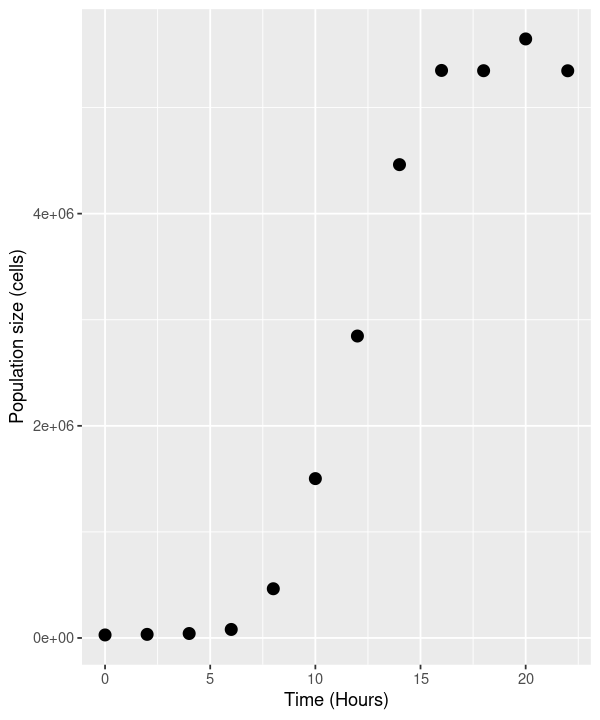

In [41]:
ggplot(data, aes(x = Time, y = N)) + 
    geom_point(size = 3) +
    labs(x = "Time (Hours)", y = "Population size (cells)")

#### Basic approach

The size of an exponentially growing population ($N$) at any given time ($t$) is given by:

$
N(t) = N_0 \cdot e^{rt} ,
$

where $N_0$ is the initial population size and $r$ is the growth rate. We can re-arrange this to give:

$
r = \frac{\log(N(t)) - \log(N_0)}{t} ,
$

That is, in exponential growth at a constant rate, the growth rate can be simply calculated as the difference in the log of two population sizes, over time. We will log-transform the data and estimate by eye where growth looks  exponential.

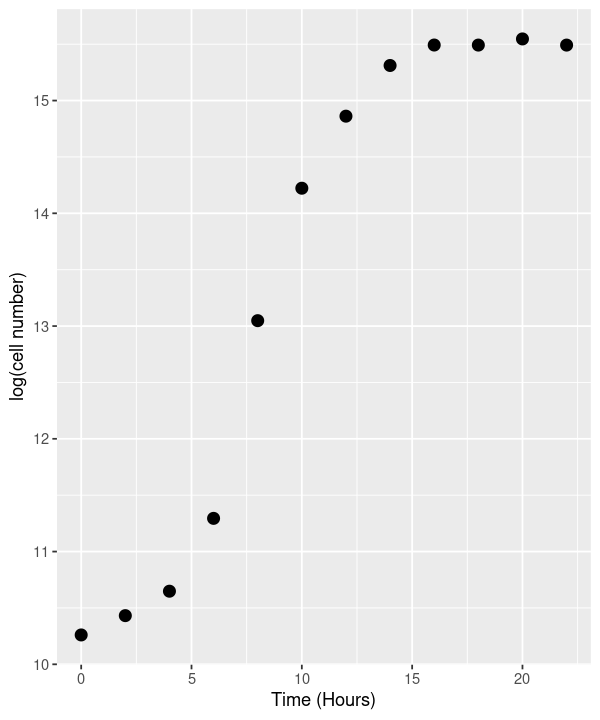

In [42]:
data$LogN <- log(data$N)

# visualise
ggplot(data, aes(x = t, y = LogN)) + 
    geom_point(size = 3) +
    labs(x = "Time (Hours)", y = "log(cell number)")

By eye the logged data looks fairly linear (beyond the initial "lag phase" of growth; see below) between hours 5 and 10, so we'll use that time-period to calculate the growth rate. 

In [43]:
(data[data$Time == 10,]$LogN - data[data$Time == 6,]$LogN)/(10-6)

[1] 0.7320383

This is our first, most basic estimate of $r$.

Or, we can decide not to eyeball the data, but just pick the maximum observed gradient of the curve. For this, we can use the the `diff()` function:

In [44]:
diff(data$LogN)

[1]  0.171269154  0.216670872  0.646099643  1.753448393  1.174704941
 [6]  0.639023868  0.449529740  0.181493482 -0.000450184  0.054490710
[11] -0.054600924

This gives all the (log) population size differences between successive timepoint pairs. The max of this is what we want, divided by the time-step.

In [45]:
max(diff(data$LogN))/2 # 2 is the difference in any successive pair of timepoints

[1] 0.8767242

#### Using OLS

But we can do better than this. To account for some error in measurement, we shouldn't really take the data points directly, but fit a linear model through them instead, where the slope gives our growth rate. This is pretty much the "traditional" way of calculating microbial growth rates &ndash; draw a straight line through the linear part of the log-transformed data.

In [46]:
lm_growth <- lm(LogN ~ Time, data = data[data$Time > 2 & data$Time < 12,])
summary(lm_growth)


Call:
lm(formula = LogN ~ Time, data = data[data$Time > 2 & data$Time < 
    12, ])

Residuals:
       3        4        5        6 
 0.21646 -0.38507  0.12076  0.04785 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   7.9366     0.5350  14.835  0.00451 **
Time          0.6238     0.0728   8.569  0.01335 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3256 on 2 degrees of freedom
Multiple R-squared:  0.9735,	Adjusted R-squared:  0.9602 
F-statistic: 73.42 on 1 and 2 DF,  p-value: 0.01335


Npw we get $r \approx 0.62$, which is probably closer to the "truth". 

But this is still not ideal because we only guessed the exponential phase by eye. We could do it better by iterating through different windows of points, comparing the slopes and finding which the highest is to give the maximum growth rate, $r_{max}$. This is called a "rolling regression". 

Or better still, we can fit a more appropriate mathematical model using NLLS!

#### Using NLLS

For starters, a classical, (somewhat) mechanistic model is the logistic equation:

$$
N_t =   \frac{N_0  N_{max} e^{r t}}{N_{max} + N_0 (e^{r t} - 1)}
$$

Here $N_t$ is population size at time $t$, $N_0$ is initial population size, $r$ is maximum growth rate (AKA $r_\text{max}$), and $N_{max}$ is carrying capacity (commonly denoted by $K$ in the ecological literature).

Let's fit it to the data. First, we need to define it as a function object:

In [52]:
logistic_model <- function(t, r_max, N_max, N_0){ # The classic logistic equation
  return(N_0 * N_max * exp(r_max * t)/(N_max + N_0 * (exp(r_max * t) - 1)))
}

Now fit it:

In [48]:
# first we need some starting parameters for the model
N_0_start <- min(data$N) # lowest population size
N_max_start <- max(data$N) # highest population size
r_max_start <- 0.62 # use our estimate from the OLS fitting from above

fit_logistic <- nlsLM(N ~ logistic_model(t = Time, r_max, N_max, N_0), data,
                      list(r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

summary(fit_logistic)


Formula: N ~ logistic_model(t = Time, r_max, N_max, N_0)

Parameters:
       Estimate Std. Error t value Pr(>|t|)    
r_max 6.309e-01  3.791e-02  16.641 4.56e-08 ***
N_0   3.317e+03  1.451e+03   2.286   0.0481 *  
N_max 5.538e+06  7.192e+04  76.995 5.32e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119200 on 9 degrees of freedom

Number of iterations to convergence: 12 
Achieved convergence tolerance: 1.49e-08


We did not pay much attention to what starting values we used in the simpler example of fitting the allometric model because the power-law model is easy to fit using NLLS, and starting far from the optimal parameters does not matter too much. Here, we used the actual data to generate more realistic start values for each of the three parameters (`r_max`, `N_0`, `N_max`) of the Logistic equation.

Now, plot the fit:

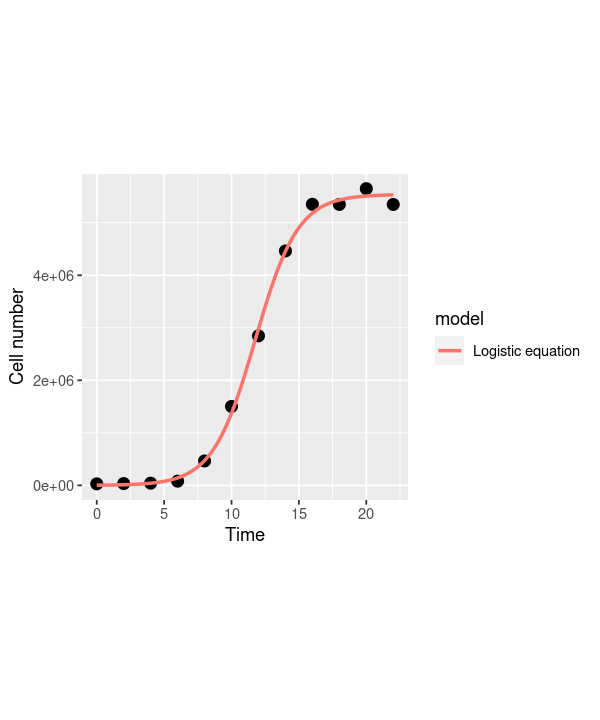

In [53]:
timepoints <- seq(0, 22, 0.1)

logistic_points <- logistic_model(t = timepoints, 
                                  r_max = coef(fit_logistic)["r_max"], 
                                  N_max = coef(fit_logistic)["N_max"], 
                                  N_0 = coef(fit_logistic)["N_0"])
df1 <- data.frame(timepoints, logistic_points)
df1$model <- "Logistic equation"
names(df1) <- c("Time", "N", "model")

ggplot(data, aes(x = Time, y = N)) +
  geom_point(size = 3) +
  geom_line(data = df1, aes(x = Time, y = N, col = model), size = 1) +
  theme(aspect.ratio=1)+ # make the plot square 
  labs(x = "Time", y = "Cell number")

That looks nice, and the $r_{max}$ estimate we get (0.64) is fairly close to what we got above with OLS fitting. 

Note that we've done this fitting to the original non transformed data, whilst the linear regressions earlier were on log transformed data. What would this function look like on a log-transformed axis?

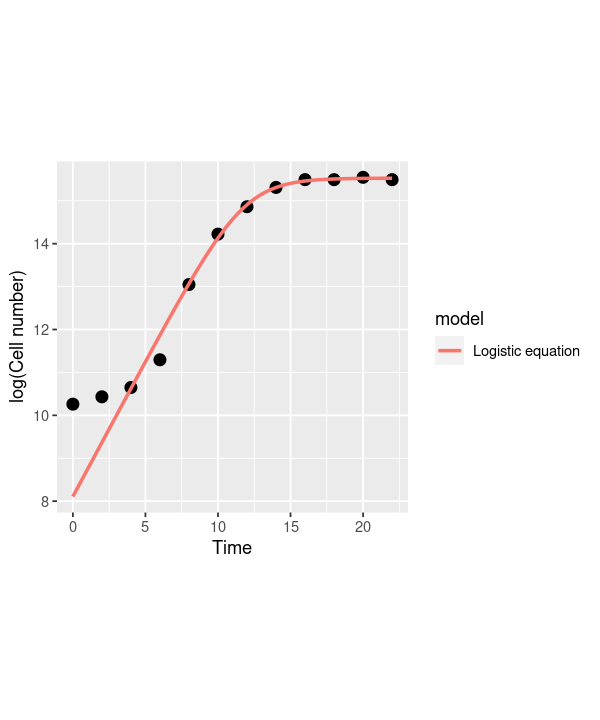

In [54]:
ggplot(data, aes(x = Time, y = LogN)) +
  geom_point(size = 3) +
  geom_line(data = df1, aes(x = Time, y = log(N), col = model), size = 1) +
  theme(aspect.ratio=1)+ 
  labs(x = "Time", y = "log(Cell number)")

The model actually diverges from the data at the lower end! This was not visible in the previous plot where you examined the model in linear scale (without taking a log) because the deviation of the model is small, and only becomes clear in the log scale. This is because of the way logarithms work. Let's have a look at this in our Cell counts "data":

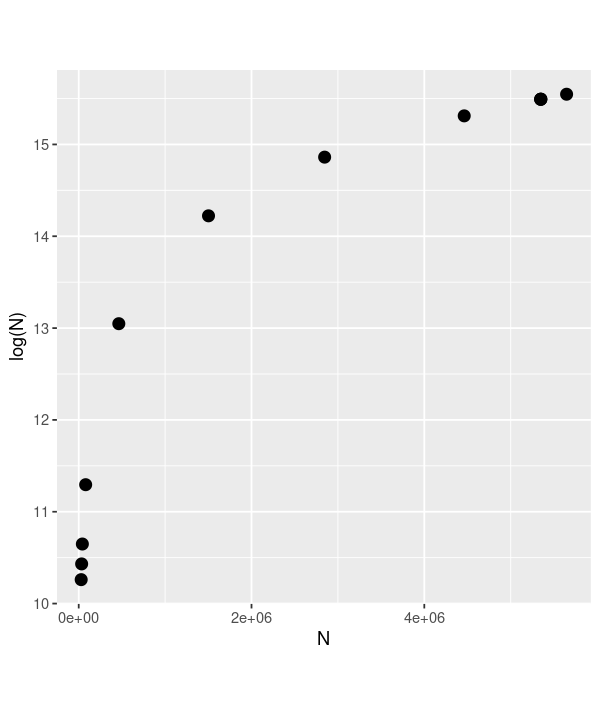

In [55]:
ggplot(data, aes(x = N, y = LogN)) +
  geom_point(size = 3) +
  theme(aspect.ratio = 1)+ 
  labs(x = "N", y = "log(N)")

As you can see the logarithm is a strongly nonlinear transformation of any sequence of real numbers, with small numbers close to zero yielding disproportionately large deviations.

```{note} 
You may play with increasing the error (by increasing the value of `sd` in synthetic data generation step above) and re-evaluating all the subsequent model fitting steps above. However, note that above some values of `sd`, you will start to get negative values of populations, especially at early time points, which will raise issues with taking a logarithm.
```

The above seen deviation of the Logistic model from the data is because this model assumes that the population is growing right from the start (Time = 0), while in "reality" (in our synthetic "data"), this is not what's happening; the population takes a while to grow truly exponentially (i.e., there is a time lag in the population growth). This time lag is seen frequently in the lab, and is also expected in nature, because when bacteria encounter fresh growth media (in the lab) or a new resource/environment (in the field), they take some time to acclimate, activating genes involved in nutrient uptake and metabolic processes, before beginning exponential growth. This is called the lag phase and can be seen in our example data where exponential growth doesn't properly begin until around the 4th hour.

To capture the lag phase, more complicated bacterial growth models have been designed. 

One of these is the modified Gompertz model (Zwietering et. al., 1990), which has been used frequently in the literature to model bacterial growth:

$$ \label{eq:Gompertz}
     \log(N_t) =  N_0 + (N_{max} - N_0) e^{-e^{r_{max} \exp(1) \frac{t_{lag} - t}{(N_{max} - N_0) \log(10)} + 1}}
$$

Here maximum growth rate ($r_{max}$) is the tangent to the inflection point, $t_{lag}$ is the x-axis intercept to this tangent (duration of the delay before the population starts growing exponentially) and $\log\left(\frac{N_{max}}{N_0}\right)$ is the asymptote of the log-transformed population growth trajectory, i.e., the log ratio of maximum population density $N_{max}$ (aka "carrying capacity") and initial cell (Population) $N_0$ density.

*Note that this model has been written in log scale.* 

Now let's fit and compare the two alternative nonlinear growth models: Logistic and Gompertz. 

First, specify the function object for the Gompertz model (we already defined the function for the Logistic model above):

In [57]:
# gompertz_model <- function(t, r_max, N_max, N_0, t_lag){ # Modified gompertz growth model (Zwietering 1990)
#     return(log(N_max / N_0) * exp(-exp(r_max * exp(1) * (t_lag - t)/log(N_max / N_0) + 1)))
# }

gompertz_model <- function(t, r_max, N_max, N_0, t_lag){ # Modified gompertz growth model (Zwietering 1990)
    return(N_0 + (N_max - N_0) * exp(-exp(r_max * exp(1) * (t_lag - t)/((N_max - N_0) * log(10)) + 1)))
}           

Again, note that unlike the Logistic growth function above, this function has been written in the log scale.    

Now let's generate some starting values for the NLLS fitting of the Gompertz model. 

As we did above for the logistic equation, let's derive the starting values by using the actual data:  

In [66]:
N_0_start <- min(data$LogN) # lowest population size, note log scale
N_max_start <- max(data$LogN) # highest population size, note log scale
r_max_start <- 0.62 # use our previous estimate from the OLS fitting from above
t_lag_start <- data$Time[which.max(diff(diff(data$LogN)))] # find last timepoint of lag phase

*So how did we find a reasonable time lag from the data?*

Let's break the last command down:

In [417]:
diff(data$LogN) # same as what we did above - get differentials

[1]  0.171269154  0.216670872  0.646099643  1.753448393  1.174704941
 [6]  0.639023868  0.449529740  0.181493482 -0.000450184  0.054490710
[11] -0.054600924

In [418]:
diff(diff(data$LogN)) # get the differentials of the differentials (approx 2nd order derivatives)

[1]  0.04540172  0.42942877  1.10734875 -0.57874345 -0.53568107 -0.18949413
 [7] -0.26803626 -0.18194367  0.05494089 -0.10909163

In [419]:
which.max(diff(diff(data$LogN))) # find the timepoint where this 2nd order derivative really takes off  

[1] 3

In [420]:
data$Time[which.max(diff(diff(data$LogN)))] # This then is a good guess for the last timepoint of the lag phase

[1] 4

Now fit the model using these start values:

In [63]:
fit_gompertz <- nlsLM(LogN ~ gompertz_model(t = Time, r_max, N_max, N_0, t_lag), data,
                      list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

You might one or more warning(s) that the model fitting iterations generated NaNs during the fitting procedure for these data (because at some point the NLLS fitting algorithm "wandered" to a combination of N_max and N_0 values that yields a NaN for log(N_max/N_0)). 

You can ignore these warning in this case. But not always &ndash; sometimes these NaNs mean that the equation is wrongly written, or that it generates NaNs across the whole range of the x-values, in which case the model is inappropriate for these data.          

Get the model summary:

In [64]:
summary(fit_gompertz)


Formula: LogN ~ gompertz_model(t = Time, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  4.80680    0.18433   26.08 5.02e-09 ***
r_max  1.86616    0.08749   21.33 2.45e-08 ***
N_0   10.39142    0.05998  173.24 1.38e-15 ***
N_max 15.54956    0.05056  307.57  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09418 on 8 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 1.49e-08


And see how the fits of the two nonlinear models compare:

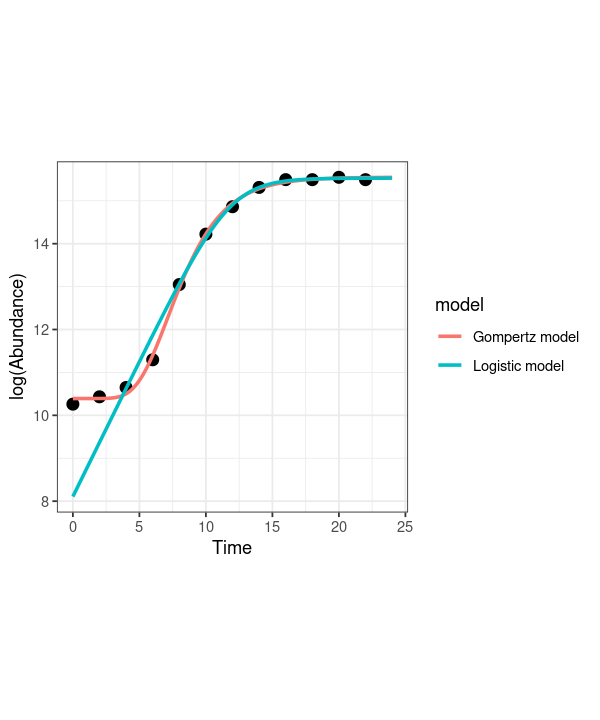

In [67]:
timepoints <- seq(0, 24, 0.1)

logistic_points <- log(logistic_model(t = timepoints, 
                                      r_max = coef(fit_logistic)["r_max"], 
                                      N_max = coef(fit_logistic)["N_max"], 
                                      N_0 = coef(fit_logistic)["N_0"]))

gompertz_points <- gompertz_model(t = timepoints, 
                                  r_max = coef(fit_gompertz)["r_max"], 
                                  N_max = coef(fit_gompertz)["N_max"], 
                                  N_0 = coef(fit_gompertz)["N_0"], 
                                  t_lag = coef(fit_gompertz)["t_lag"])

df1 <- data.frame(timepoints, logistic_points)
df1$model <- "Logistic model"
names(df1) <- c("Time", "LogN", "model")

df2 <- data.frame(timepoints, gompertz_points)
df2$model <- "Gompertz model"
names(df2) <- c("Time", "LogN", "model")

model_frame <- rbind(df1, df2)

ggplot(data, aes(x = Time, y = LogN)) +
  geom_point(size = 3) +
  geom_line(data = model_frame, aes(x = Time, y = LogN, col = model), size = 1) +
    theme_bw() + # make the background white
    theme(aspect.ratio=1)+ # make the plot square 
    labs(x = "Time", y = "log(Abundance)")

Clearly, the Gompertz model fits way better than the logistic growth equation in this case! Note also that there is a big difference in the fitted value of $r_{max}$ from the two models; the value is much lower from the Logistic model because it ignores the lag phase, including it into the exponential growth phase. 

You can now perform model selection like you did above in the allometric scaling example.    

### Exercises

(a) Calculate the confidence intervals on the parameters of each of the two fitted models, and use model selection (using AIC and/or BIC) as you did before to see if you can determine the best-fitting model among the three.

(b) Alternatively, for a different random sequence of fluctuations, one or more of the models may fail to fit (a `singular gradiant matrix` error). Try repeating the above fitting with a different random seed (change the integers given to the `random.seed( )` function), or increase the sampling error by increasing the standard deviation and see if it happens. If/when the NLLS optimization does fail to converge (the RSS minimum was not found), you can try to fix it by changing the starting values. 

(c) Repeat the model comparison exercise 1000 times (You will have to write a loop), and determine if/whether one model generally wins more often than the others. Note that each run will generate a slightly different dataset, because we are adding a vector of random errors every time the "data" are generated. This may result in failure of the NLLS fitting to converge, in which case you will need to use the [`try()` or `tryCatch` functions](https://nbviewer.jupyter.org/github/mhasoba/TheMulQuaBio/blob/master/notebooks/07-R.ipynb).

(d) Repeat (b), but increase the error by increasing the standard deviation of the normal error distribution, and see if there are differences in the robustness of the models to sampling/experimental errors. You may also want to try changing the distribution of the errors to some non-normal distribution and see what happens.

Model fitting using Maximum Likelihood
--------------------------------------

Above we learned how to fit a mathematical model/equation to data by using the Least Squares method (linear or nonlinear). That is, we choose the parameters of model being fitted (e.g., straight line) to minimize the sum of the squares of the residuals/errors sround the fitted model. An alternative to minimizing the sum of squared errors is to find parameters to the function such that the *likelihood* of the parameters, given the data and the model, is maximized. Please see the [lectures](https://github.com/vectorbite/VBiTraining2/tree/master/lectures) for the theoretical background to the following R examples.

We will first implement the (negative log) likelihood for simple linear regression (SLR) in R. Recall that SLR assumes every observation in the dataset was generated by the model:

$$Y_i = \beta_0 + \beta_1 X_i + \varepsilon_i, \;\;\; \varepsilon_i \stackrel{\mathrm{iid}}{\sim} \mathrm{N}(0, \sigma^2)
$$

That is, this is a model for the *conditional distribution* of $Y$ given $X$. The pdf for the normal distribution is given by

$$
f(x) = \frac{1}{\sqrt{2\sigma^2 \pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2} \right)
$$

In the SLR model, the conditional distribution has *this* distribution. 

That is, for any single observation, $y_i$
$$
f(y_i|\beta_0, \beta_1, x_i) = \frac{1}{\sqrt{2\sigma^2 \pi}} \exp\left(-\frac{(y_i-(\beta_0+\beta_1 x_i))^2}{2\sigma^2} \right)
$$

Interpreting this function as a function of the parameters $\theta=\{ \beta_0, \beta_1, \sigma \}$, then it gives us the likelihood of the $i^{\mathrm{th}}$ data point. 

As we did for the simple binomial distribution (see [lecture](https://github.com/vectorbite/VBiTraining2/tree/master/lectures)), we can use this to estimate the parameters of the model.

### Implementing the Likelihood in R

First, we need to build an R function that returns the (negative log) likelihood for simple linear regression (it is negative log because the log of likelihood is itself negative):

In [41]:
nll.slr <- function(par, dat, ...){
  args <- list(...)
  
  b0 <- par[1]
  b1 <- par[2]
  X <- dat$X
  Y <- dat$Y
  if(!is.na(args$sigma)){
      sigma <- args$sigma
  } else 
      sigma <- par[3]

  mu <- b0+b1*X
  
  return(-sum(dnorm(Y, mean=mu, sd=sigma, log=TRUE)))
}

Note that we do something a bit different here (the "`...`" bit). We do it this way because we want to be able to use R's `optim()` function later.

The `dnorm()` function calculates the logged (the `log=TRUE` argument) probability of observing Y given mu, sigma and that X.  

The negative sign on `sum()` is because the `optim()` function in R will minimize the negative log-likelihood, which is a sum: Recall that The log-likelihood of the parameters $\theta$ being true given data x equals to the sum of the logged probability densities of observing the data x given parameters $\theta$. We want to maximize this (log-) likelihood using `optim()`.

Let's generate some simulated data, assuming that: $\beta_0=$ `b0`, $\beta_1=$ `b1`, and $\sigma=$ `sigma`. For this, we will generate random deviations to simulate sampling or measurement error around an otherwise perfect line of data values:

In [42]:
set.seed(123)
n <- 30
b0 <- 10
b1 <- 3
sigma <- 2
X <- rnorm(n, mean=3, sd=7)
Y <- b0 + b1*X + rnorm(n, mean=0, sd=sigma)
dat <- data.frame(X=X, Y=Y) # convert to a data frame

In the first line, we `set.seed()` to ensure that we can reproduce the results. The seed number you choose is the starting point used in the generation of a sequence of random numbers. No plot the "data":

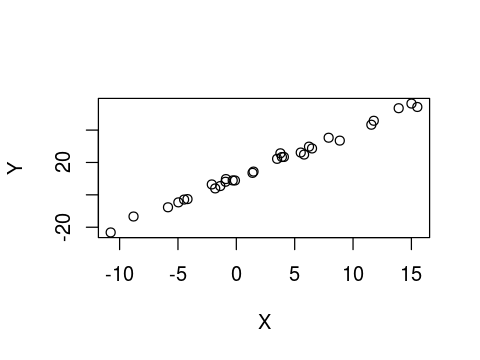

In [43]:
plot(X, Y)

#### Likelihood profile

For now, let's assume that we know what $\beta_1$ is. Let's build a likelihood profile for the simulated data:

In [44]:
N <- 50
b0s <- seq(5, 15, length=N)
mynll <- rep(NA, length=50)
for(i in 1:N){
  mynll[i] <- nll.slr(par=c(b0s[i],b1), dat=dat, sigma=sigma)
}

That is, we calculate the negative log-likelihood for fixed b1, across a range (5 - 15) of b0.  

Now plot the profile:

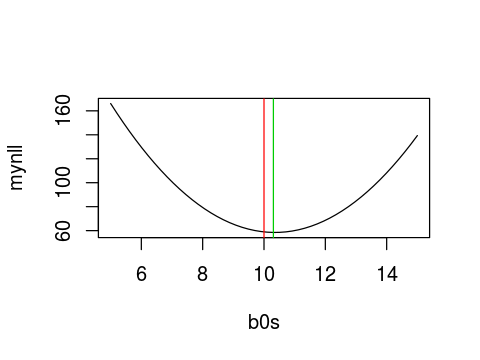

In [45]:
plot(b0s, mynll, type="l")
abline(v=b0, col=2)
abline(v=b0s[which.min(mynll)], col=3)

The true value for b0 (10) is the red line, while the value that minimizes the log-likelihood (i.e., maximizes the negative log-likelihood) is the green line. These are not the same because maximum likelihood is providing an *estimate* of the true value given the measurement errors (that we ourselves generated in tgis synthetic dataset).  

#### Likelihood surface

If we wanted to estimate both $\beta_0$ and $\beta_1$ (two parameters), we need to deal with a two-dimensional maximum likelihood surface. The simplest approach is to do a *grid search* to find this  likelihood surface.

10.00000,3.00
10.48485,2.96


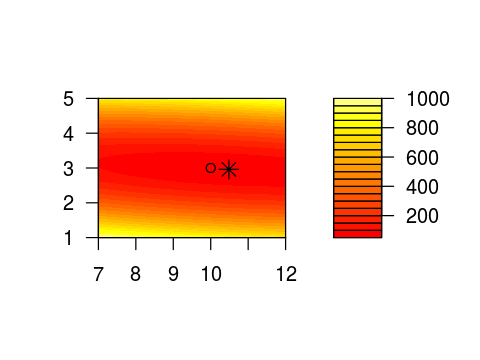

In [46]:
N0 <- 100
N1 <- 101
b0s <- seq(7,12, length=N0)
b1s <- seq(1,5, length=N1)

mynll<-matrix(NA, nrow=N0, ncol=N1)
for(i in 1:N0){
  for(j in 1:N1) mynll[i,j]<-nll.slr(par=c(b0s[i],b1s[j]), dat=dat, sigma=sigma)
}

ww <- which(mynll==min(mynll), arr.ind=TRUE)

b0.est <- b0s[ww[1]]
b1.est <- b1s[ww[2]]
rbind(c(b0, b1), c(b0.est, b1.est))

filled.contour(x = b0s, y = b1s, z= mynll, col=heat.colors(21), 
               plot.axes = {axis(1); axis(2); points(b0,b1, pch=21); 
                            points(b0.est, b1.est, pch=8, cex=1.5); xlab="b0"; ylab="b1"})

There is a lot going on here. Make sure you ask one of us if some of the code does not make sense!

Again, note that the true parameter combination (asterisk) and the one what maximizes the negative log-likelihood (circle) are different.

#### Conditional Likelihood
We can also look at the conditional surfaces (i.e., we look at the slice around whatever the best estimate is for the other parameter):

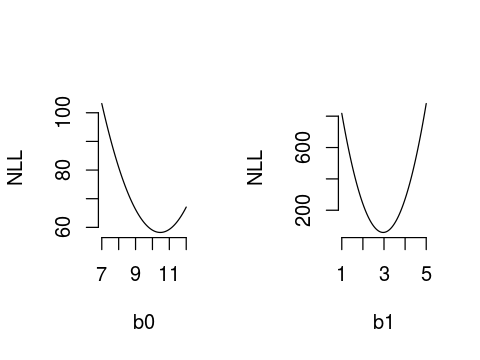

In [47]:
par(mfrow=c(1,2), bty="n")
plot(b0s, mynll[,ww[2]], type="l", xlab="b0", ylab="NLL")
plot(b1s, mynll[ww[1],], type="l", xlab="b1", ylab="NLL")

### Alternatives to Grid Search

There are many alternative methods to grid searches. Since we are seeking to minimize an arbitrary function (the negative log likelihood) we typically use a descent method to perform general optimization.

There are lots of options implemented in the `optim`function in R. We won't go into the details of these methods, due to time constraints. However, typically one would most commonly use:

* Brent's method: for 1-D search within a bounding box, only
* L-BFGS-B (limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm with bounding box constraints): a quasi-Newton method, used for higher dimensions, when you want to be able to put simple limits on your search area.  
 

### Maximum Likelihood using `optim()`

We can now do the fitting. This involves optimization (to find the appropriate parameter values that achieve the maximum of the likelihood surface above). For this, we will use R's versatile `optim()` function.

The first argument for `optim()` is the function that you want to minimize, and the second is a vector of starting values for your parameters (as always, do a`?optim`). After the main arguments, you can add what you need to evaluate your function (e.g. `sigma` ). The addtional argument sigma can be "fed" to `nll.slr` because we use the `...` convention when defining it.

In [48]:
fit <- optim(nll.slr, par=c(2, 1), method="L-BFGS-B", ## this is a n-D method
              lower=-Inf, upper=Inf, dat=dat, sigma=sigma)

fit

$par
[1] 10.458935  2.961704

$value
[1] 58.22473

$counts
function gradient 
      12       12 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

Easy as pie (once you have the recipe)! We can also fit sigma as the same time if we want:

In [49]:
fit <- optim(nll.slr, par=c(2, 1, 5), method="L-BFGS-B", ## this is a n-D method
              lower=c(-Inf, -Inf, 0.1), upper=Inf, dat=dat, sigma=NA)
fit$par

[1] 10.458945  2.961704  1.621689

The starting values (b0 = 2, b1  = 1, sigma = 5) need to be assigned as we would do for NLLS. Also note that much like NLLS, we have bounded the parameters. The exact starting values are not too important in this case (try changing them see what happens).

Now visualize the fit:

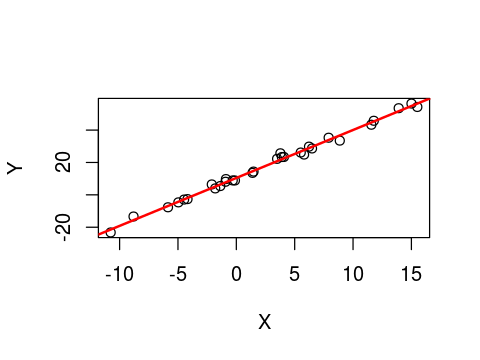

In [50]:
plot(X, Y)
abline(a=fit$par[1], b=fit$par[2], col=2, lwd=2)

### Confidence intervals

The joint distribution of the MLEs are asymptotically Normally distributed. Given this, if you are minimizing the negative log likelihood (NLL) then the covariance matrix of the estimates is (asymptotically) the inverse of the Hessian matrix. The Hessian matrix evalutes the second derivatives of the NLL (numerically here), which gives us information about the curvature the likelihood. Thus we can use the Hessian to estimate confidence intervals:

In [51]:
fit <- optim(nll.slr, par=c(2, 1), method="L-BFGS-B", hessian=TRUE, lower=-Inf, upper=Inf, dat=dat, sigma=sigma)

fisher_info<-solve(fit$hessian)
est_sigma<-sqrt(diag(fisher_info))
upper<-fit$par+1.96*est_sigma
lower<-fit$par-1.96*est_sigma
interval<-data.frame(value=fit$par, upper=upper, lower=lower)
interval

value,upper,lower
10.458935,11.228565,9.689305
2.961704,3.067705,2.855704


### Comparison to fitting with least squares

We can, of course, simply fit the model with lest squares using the `lm()` function:

In [52]:
lmfit<-lm(Y~X)

summary(lmfit)$coeff

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),10.458936,0.32957007,31.73509,1.699822e-23
X,2.961704,0.04539126,65.24834,3.874555e-32


The estimates we get using `optim()` are almost identical to the estimates that we obtain here, and the standard errors on the intercept and slope are very similar to those we calculated from the Hessian (est_sigma= `r est_sigma`). 

### Model Selection

You can use [AIC or BIC as you did in NLLS](#Comparing-models) using the likelihood you have calculated. 

You can also use the Likelihood Ratio Test (LRT).

#### Exercises <a id='MLE_Exercises'></a> 

Try MLE fitting for the allometric trait data example [above](#Allometric-scaling-of-traits). You will use the same data + functions that you used to practice fitting curves using non-linear least squares methods. You have two options here. The easier one is to convert the power law model to a straight line model by taking a log (explained the Allometry [Exercises](#Allom_Exercises). Specifically,

(a) Using the [`nll.slr`](#Implementing-the-Likelihood-in-R) function as an example, write a function that calculates the negative log likelihood as a function of the parameters describing your trait and any additional parameters you need for an appropriate noise distribution (e.g., $\sigma$ if you have normally distributed errors).

(b) For at least one of your parameters plot a likelihood profile given your data, with the other parametes fixed.

(c) Use the `optim` function to find the MLE of the same parameter and indicate this on your likelihood profile.

(d) Obtain a confidence interval for your estimate.

A more challenging option is to fit the allometry data directly to the power law equation. You would need to assume a log-normal distribution for the errors instead of normal, in this case.   

Fitting Models the Bayesian way
-------------------------------

Recall from the [lectures](https://github.com/vectorbite/VBiTraining2/tree/master/lectures) that for Bayesian model fitting/inference, we need to: 


1. **Assess MCMC convergence**: MCMC is family of algorithm for sampling probability distributions so that it can be adequately characterized (in the Bayesian context the posterior distribution). The MCMC procedure reaches *convergence* once we have sufficient random draws from the posterior distribution. To assess convergence we look at trace plots. The goal is to get "fuzzy caterpillars"-looking curves. 

2. **Summarize MCMC draws**: Summarize and visualize outcome of the random draws using histograms for all draws for each parameter, and calculate expectation, variance, credibility interval, etc.

3. **Prior Sensitivity**: Assess prior sensitivity by changing prior values and check whether it affects the results or not. If it does, that means that the results are too sensitive to that prior, not good!

4. **Make inferences**: We use the values from item (2) to make inferences and answer the research question.

Because likelihoods form the basis for Bayesian model fitting, we will first do an exercise to understand their calculation.    

### A Likelihoods exercise

#### The Binomial Distribution

The Binomial distribution is used to model the number of "successes" in a set of trials (e.g., number of heads when you flip a coin $N$ times). The pmf is  
$$
{N \choose x} p^x(1-p)^{N-x}
$$
such that $\mathrm{E}[x]=Np$. Throughout this "experiment", you will assume that your experiment consists of flipping 20 coins, so that $N=20$.

Let's use the Binomial distribution to practice two methods of estimating parameters for a probability distribution: method of moments and maximum likelihood.

##### Simulating from the Binomial using R

First take 50 draws from a binomial (using _rbinom_) for each $p\in$ 0.1, 0.5, 0.8 with $N=20$. For this, lets set seed so that we can reproduce this exact sequence of sampling (why?):

In [53]:
set.seed(54321)

In [54]:
## 50 draws with each p 
pp<-c(0.1, 0.5, 0.8)
N<-20
reps<-50 

Now plot the histograms of these draws together with the density functions.

In [55]:
## histograms + density here
x<-seq(0, 50, by=1)
par(mfrow=c(1,3), bty="n")

# Write more code here

**Q1: Do the histograms look like the distributions for all 3 values of $p$? If not, what do you think is going on?**

You'll notice that for $p=0.1$ the histogram and densities don't look quite the same -- the `hist()` function is lumping together the zeros and ones which makes it look off. This is typical for distributions that are truncated.

#### Method of Moments (MoM) Estimators

To obtain a method of moments estimator, we equate the theoretical moments (which will be a function of the parameters of the distribution) with the corresponding sample moments, and solve for the parameters in order to obtain an estimate. For the binomial distribution, there is only one parameter, $p$. 

**Q2: Given the analytic expected value, above, and assuming that the sample mean is $m$ (the mean number of observed heads across replicates), what is the MoM estimator for $p$?**

Now calculate the MoM estimator for each of your 3 sets of simulated data sets to get the estimates for each of your values of $p$.

In [56]:
## MOM estimators for 3 simulated sets


**Q3: How good are your estimates for $p$? Do you get something close to the true value?**

For 1 of your values of $p$, take 20 draws from the binomial with $N=20$ and calculate the MoM. Repeat this 100 times (hint: the `replicate()` and `lapply` functions may be useful.) Make a histogram of your estimates, and  add a line/point to the plot to indicate the real value of $p$ that you used to simulate the data. 

In [57]:
## MoM estimates, histogram 

**Q4: Is the MoM successfully estimating $p$? Does your histogram for $p$ look more or less normal? If so, what theorem might explain why this would be the case?** 

#### MLE for Binomial Distribution

##### Likelihood and Log Likelihood

Imagine that you flip a coin $N$ times, and then repeat the experiment $n$ times. Thus, you have data $x=x`1, x`2, \dots x`n$ that are the number of times you observed a head in each trial. $p$ is the probability of obtaining a head. 

**Q5: Write down the likelihood and log-likelihood for the data. Take the derivative of the negative log-likelihood, set this equal to zero, and find the MLE, $\hat{p}$.** 


#### Computing the likelihood and MLE in R

Simulate some data with $p=0.25$, $N=10$, and 10 replicates. Calculate the negative log-likelihood of your simulated data across a range of $p$ (from 0 to 1), and plot them. You may do this by using the built in functions in R (specifically `dbinom`) or write your own function. This is called a "likelihood profile''. Plot your likelihood profile with a line indicating the true value of $p$. Add lines indicating the MLE $\hat{p}$ and the MoM estimator for $p$ to your likelihood profile. 

In [58]:
pp<-.25
N<-10
reps<-10
## Make one set of data

## the likelihood is always exactly zero
## at p=0,1, so I skip those values
ps<-seq(0.01, 0.99, by=0.01) 

## Likelihood


## MLE/MoM estimators 

## now plot the negative log likelihood profile


**Q6: How does your MLE compare to the true parameter value? How could you estimate the MLE from the likelihood profile if you didn't have a way to calculate the MLE directly? If you chose another version of the random seed, do you get the same answer?**

### Example: Midge Wing Length

We will use this simple example to go through the steps of assessing a Bayesian model and we'll see that MCMC can allow us to approximate the posterior distribution.

Grogan and Wirth (1981) provide data on the wing length (in millimeters) of nine members of a species of midge (small, two-winged flies). 

From these measurements we wish to make inference about the population mean $\mu$.

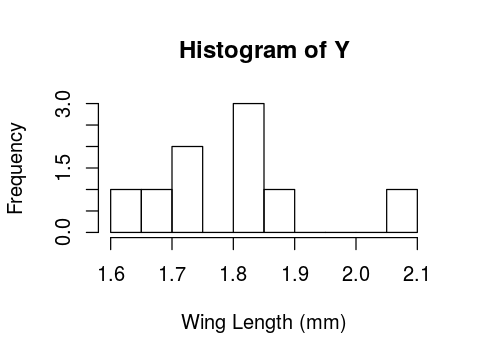

In [59]:
WL.data <- read.csv("../data/MidgeWingLength.csv")
Y <- WL.data$WingLength
n <- length(Y)

hist(Y,breaks=10,xlab="Wing Length (mm)") 

### Non-Bayesian analysis

We might expect that these midge data could be draws from a _Normal_ distribution $\mathcal{N}(\mu, \sigma^2)$. Recall that the MLEs for $\mu$ and $\sigma^2$ here are simply the _sample mean_ and _sample variance_ respectively:

In [60]:
m<-sum(Y)/n
s2<-sum((Y-m)^2)/(n-1)
round(c(m, s2), 3)

[1] 1.804 0.017

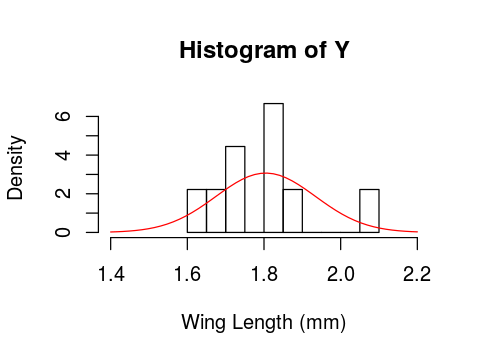

In [61]:
x<-seq(1.4,2.2, length=50)
hist(Y,breaks=10,xlab="Wing Length (mm)", xlim=c(1.4, 2.2), freq=FALSE) 
lines(x, dnorm(x, mean=m, sd=sqrt(s2)), col=2)

**NOTE:** I've plotted the estimate of the _population_ distribution here, but this is not the ***predictive distribution*** (which would be a Student T because we're estimating both the mean and variance...).

-----

The non-Bayesian version here has the advantage of being quick and familiar. However, from our point of view it has two weaknesses:

1. Because we have so few data points estimates of the accuracy of our predictions aren't available. 9 points is only barely enough to estimate a mean, so we don't trust any of the variance calculations.

2. We can't easily incorporate things that we might already know about midges into our analysis. 

Let's see how we can do a similar analysis using a Bayesian approach, first analytically, and the with JAGS.

### Setting up the Bayesian Model

We need to define the likelihood and the priors for our Bayesian analysis. Given the analysis that we've just done, let's assume that our data come from a normal distribution with unknown mean, $\mu$ but that we know the variance is $\sigma^2 = 0.025$. That is:

$$
\mathbf{Y} \stackrel{\mathrm{iid}}{\sim} \mathcal{N}(\mu, 0.025^2)
$$


#### Prior Information

Studies from other populations suggest that wing lengths are usually around 1.9 mm, so we set $\mu_0 = 1.9$

We also know that lengths must be positive ($\mu >0$)

We can approximate this restriction with a normal prior distribution for $\mu$ as follows:

Since most of the normal density is within two standard deviations of the mean we choose $\tau^2_0$ so that

$$ \mu_0 - 2\sigma_0 >0 \Rightarrow \sigma_0 <1.9/2 = 0.95 $$
I will choose $\sigma_0=0.8$ here. Thus our prior for mu will be:
$$
\mu \sim \mathcal{N}(1.9, 0.8^2)
$$

----

Together, then, our full model is:
\begin{align*}
\mathbf{Y} & \stackrel{\mathrm{iid}}{\sim} \mathcal{N}(\mu, 0.025^2)\\
\mu &\sim \mathcal{N}(1.9, 0.8^2)
\end{align*}

### Analytic Posterior

For this very simple case it is easy to write down the posterior distribution (up to some constant). First, note that the likehood for the data can be written as 

\begin{align*}
\mathcal{L} &\propto \prod_{i=1}^n \frac{1}{\sigma} \exp\left(-\frac{1}{2\sigma^2}(Y_i-\mu)^2 \right) \\
& =  \frac{1}{\sigma^n} \exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^n (Y_i-\mu)^2 \right)\\
& \propto \exp\left(-\frac{n}{2\sigma^2} (\bar{Y}-\mu)^2 \right)
\end{align*}

Multiplying the prior through we get the following for the posterior:

$$
\mathrm{P}(\mu|\mathbf{Y}) \propto \exp \left(-\frac{n}{2\sigma^2} (\bar{Y}-\mu)^2 \right) \exp\left(-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2 \right)
$$

You can re-arrange, complete the square, etc, to get a new expression that is like

$$
\mathrm{P}(\mu|\mathbf{Y}) \propto \exp \left(-\frac{1}{2\sigma_p^2} (\mu_p-\mu)^2 \right)
$$

where 

\begin{align*}
\mu_p & = \frac{n\sigma_0^2}{\sigma^2 + n\sigma_0^2} \bar{Y} +  \frac{\sigma^2}{\frac{\sigma^2}{n} + \sigma_0^2} \mu_0\\
& \\
\sigma_p^2 & = \left( \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} \right)^{-1}
\end{align*}

Instead of writing this last in terms of the variances, we could instead use precision (the inverse variance) which gives a simpler expression:

$$
\tau_p = n\tau + \tau_0
$$

Just like in our earlier example, our estimate of the mean is a weighted average of the data and the prior, with the variance being determined by the data and prior variances.

So lets write a little function to calculate $\mu_p$ and $\tau_p$ and the plug in our numbers:

In [62]:
tau.post<-function(tau, tau0, n){n*tau + tau0}
mu.post<-function(Ybar, mu0, sig20, sig2, n){
  weight<-sig2+n*sig20
  
  return(n*sig20*Ybar/weight + sig2*mu0/weight)
}

Let's plot 3 things together -- the data histogram, the prior, and the posterior:

In [63]:
mu0 <- 1.9
s20 <- 0.8
s2<- 0.025 ## "true" variance

mp<-mu.post(Ybar=m, mu0=mu0, sig20=s20, sig2=s2, n=n)
tp<-tau.post(tau=1/s2, tau0=1/s20, n=n)

Let's plot the result:

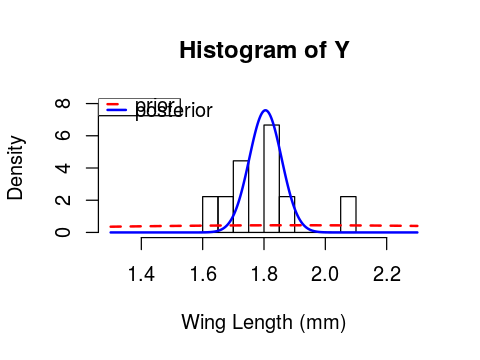

In [64]:
x<-seq(1.3,2.3, length=1000)
hist(Y,breaks=10,xlab="Wing Length (mm)", xlim=c(1.3, 2.3),
     freq=FALSE, ylim=c(0,8)) 
lines(x, dnorm(x, mean=mu0, sd=sqrt(s20)), col=2, lty=2, lwd=2) ## prior
lines(x, dnorm(x, mean=mp, sd=sqrt(1/tp)), col=4, lwd=2) ## posterior
legend("topleft", legend=c("prior", "posterior"), col=c(2,4), lty=c(2,1), lwd=2)

### Exercise: Prior sensitivity

Change the values of the mean and the variance that you choose for the prior ("hyperparameters"). What does this do to the posterior distribution. E.g., what happens if the variance you choose is small, and $\mu_0 =2.5$ or so. Is this what you expect?


### Numerical evaluation of the posterior with JAGS

Let's show that we can get the same thing from JAGS that we were able to get from the analytic results. You'll need to make sure you have installed JAGS (which must be done outside of R) and then the libraries `rjags` and `coda`.

In [65]:
# Load libraries
require(rjags) # does the fitting
require(coda) # makes diagnostic plots
##require(mcmcplots) # another option for diagnostic plots

Loading required package: rjags
Loading required package: coda
Error: package or namespace load failed for ‘rjags’:
 .onLoad failed in loadNamespace() for 'rjags', details:
  call: load.module("basemod", quiet = TRUE)
  error: File not found: /usr/lib/JAGS/modules-4/basemod.so


#### Specifying the model

First we must encode our choices for our data model and priors to pass them to the fitting routines in JAGS. This involves setting up a ${\tt model}$ that includes the likelihood for each data point and a prior for every parameter we want to estimate. Here is an example of how we would do this for the simple model we fit for the midge data (note that JAGS uses the precision instead of the variance or sd for the normal distribution:

In [66]:
model1 <- "model{

  ## Likelihood
  for(i in 1:n){
    Y[i] ~ dnorm(mu,tau)
  }

  ## Prior for mu
  mu        ~ dnorm(mu0,tau0)

} ## close model  
"

Now create the JAGS model:

In [67]:
model <- jags.model(textConnection(model1), 
                    n.chains = 1, ## usually do more
                    data = list(Y=Y,n=n, ## data
                                mu0=mu0, tau0=1/s20, ## hyperparams
                                tau = 1/s2 ## known precision
                                ),
                    inits=list(mu=3) ## setting an starting val
                    )

ERROR: Error in jags.model(textConnection(model1), n.chains = 1, data = list(Y = Y, : could not find function "jags.model"


Now we'll run the MCMC and, see how the output looks for a short chain with no burnin:

In [68]:
samp <- coda.samples(model, 
        variable.names=c("mu"), 
        n.iter=1000, progress.bar="none")

plot(samp)

ERROR: Error in coda.samples(model, variable.names = c("mu"), n.iter = 1000, : could not find function "coda.samples"


MCMC is a rejection algorithm that often needs to converge or "burn-in" -- that is we need to potentially move until we're taking draws from the correct distribution. Unlike for optimization problems, this does not mean  that the algorithm :eads toward a single value. Instead we're looking for a pattern where the draws are seemingly unrelated and random. To assess convergence we look at trace plots, the goal is to get traces that look like "fuzzy caterpillars". 

Sometimes at the beginning of a run, if we start far from the area near the posterior mean of the parameter, we will instead get something that looks like a trending time series. If this is the case we have to drop the samples that were taken during the burn-in phase. Here's an example of how to do that:

In [69]:
update(model, 10000, progress.bar="none") # Burnin for 10000 samples

samp <- coda.samples(model, 
        variable.names=c("mu"), 
        n.iter=20000, progress.bar="none")

plot(samp)

ERROR: Error in update(model, 10000, progress.bar = "none"): object 'model' not found


This is a very fuzzy caterpillar!

We can also use the summary function to examine the samples generated:

In [70]:
summary(samp)

ERROR: Error in summary(samp): object 'samp' not found


Let's compare these draws to what we got with our analytic solution:

In [71]:
x<-seq(1.3,2.3, length=1000)
hist(samp[[1]], xlab="mu", xlim=c(1.3, 2.3),
     freq=FALSE, ylim=c(0,8), main ="posterior samples") 
lines(x, dnorm(x, mean=mu0, sd=sqrt(s20)), col=2, lty=2, lwd=2) ## prior
lines(x, dnorm(x, mean=mp, sd=sqrt(1/tp)), col=4, lwd=2) ## posterior
legend("topleft", legend=c("prior", "analytic posterior"), col=c(2,4), lty=c(2,1), lwd=2)

ERROR: Error in hist(samp[[1]], xlab = "mu", xlim = c(1.3, 2.3), freq = FALSE, : object 'samp' not found


It worked! 


As with the analytic approach, it's always a good idea when you run your analyses to see how sensitive is your result to the priors you choose. Unless you are purposefully choosing an informative prior, we usually want the prior and posterior to look different.


### Estimating the population variance
 
One advantage of the numerical approach is that we can choose almost anything we want for the priors on multiple parameters without worrying if they are conjugate, or if we want to include additional information. For example, let's say that, not, we want to force the mean to be positive (and also the data, perhaps), and concurrently estimate the variance. Here is a possible model.

In [72]:
model2 <- "model{

  # Likelihood
  for(i in 1:n){
    Y[i] ~ dnorm(mu,tau) T(0,) ## truncates at 0
  }

  # Prior for mu
  mu    ~ dnorm(mu0,tau0)

  # Prior for the precision
  tau   ~ dgamma(a, b)

  # Compute the variance
  s2       <- 1/tau
}"

## hyperparams for tau
a   <- 0.01
b   <- 0.01

m2 <- jags.model(textConnection(model2), 
                    n.chains = 1,
                    data = list(Y=Y, n=n,
                               mu0=mu0, tau0=1/s20, ## mu hyperparams
                                a=a, b=b ## tau hyperparams
                                ),
                    inits=list(mu=3, tau=10) ## starting vals
                )

samp <- coda.samples(m2, 
        variable.names=c("mu","s2"), 
        n.iter=1000, progress.bar="none")

plot(samp)

summary(samp)

ERROR: Error in jags.model(textConnection(model2), n.chains = 1, data = list(Y = Y, : could not find function "jags.model"


Now we plot each with their priors:

In [73]:
par(mfrow=c(1,2), bty="n")

hist(samp[[1]][,1], xlab="samples of mu", main="mu")
lines(x, dnorm(x, mean=mu0, sd=sqrt(s20)), 
      col=2, lty=2, lwd=2) ## prior

x2<-seq(0, 200, length=1000)
hist(1/samp[[1]][,2], xlab="samples of tau", main="tau")
lines(x2, dgamma(x2, shape = a, rate = b), 
      col=2, lty=2, lwd=2) ## prior

ERROR: Error in hist(samp[[1]][, 1], xlab = "samples of mu", main = "mu"): object 'samp' not found


We also want to look at the joint distribution of $\mu$ and $\sigma^2$:

In [74]:
plot(as.numeric(samp[[1]][,1]), samp[[1]][,2], xlab="mu", ylab="s2")

ERROR: Error in plot(as.numeric(samp[[1]][, 1]), samp[[1]][, 2], xlab = "mu", : object 'samp' not found


### Exercise: Updating the Bayesian model

Redo the previous analysis placing a gamma prior on $\mu$ as well. Set the prior so that the mean and variance are the same as in the normal example from above (use moment matching). Do you get something similar?

### Aedes data revisited using Bayesian fitting

Now let's do some Bayesian model fitting to *Aedes* thermal performance data. Lets try out the `R2jags` package for this.

In [75]:
require(R2jags) # fitting
require(coda) # diagnostic plots
set.seed(1234)

Loading required package: R2jags
Loading required package: rjags
Error: package or namespace load failed for ‘rjags’:
 .onLoad failed in loadNamespace() for 'rjags', details:
  call: load.module("basemod", quiet = TRUE)
  error: File not found: /usr/lib/JAGS/modules-4/basemod.so


Load the data:

In [76]:
Aaeg.data <- read.csv("../data/AeaegyptiTraitData.csv")

#### The Data

These data are traits from *Aedes aegypti* mosquitoes measured across temperature in lab experiments. The traits we have data on thermal performance are:
- pEA: proportion surviving from egg to adulthood  
- MDR: mosquito development rate  
- PDR: parasite development rate (= 1/EIP the extrinsic incubation period)  
- $\mu$ (mu): death rate (= 1/longevity)  

Note that some of the traits come in multiple forms (e.g., $\mu$ and 1/$\mu$, PDR and EIP).

Have a look at the data:

In [77]:
head(Aaeg.data)

trait.name,T,trait,ref,trait2,trait2.name
pEA,22,0.90812,Westbrook_Thesis_2010,NA,NA
pEA,27,0.93590,Westbrook_Thesis_2010,NA,NA
pEA,32,0.81944,Westbrook_Thesis_2010,NA,NA
MDR,22,0.09174,Westbrook_Thesis_2010,NA,NA
MDR,27,0.13587,Westbrook_Thesis_2010,NA,NA
MDR,32,0.15823,Westbrook_Thesis_2010,NA,NA


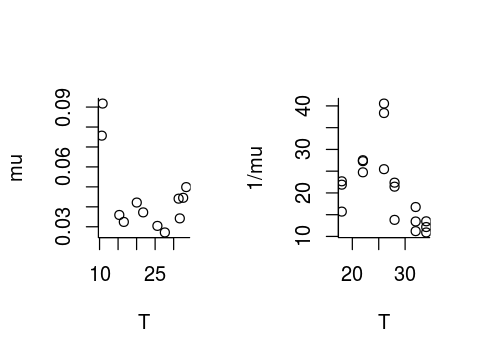

In [78]:
mu.data <- subset(Aaeg.data, trait.name == "mu")
lf.data <- subset(Aaeg.data, trait.name == "1/mu")
par(mfrow=c(1,2), bty="l") 
plot(trait ~ T, data = mu.data, ylab="mu")
plot(trait ~ T, data = lf.data, ylab="1/mu")

Note that the $\mu$ data is u-shaped and the lifespan data is unimodal (hump-shaped).  

Since thermal biology theory is based on unimodal thermal responses, we want to fit the trait as lifespan instead of $\mu$. Thus, we'll need to convert the $\mu$ data to lifespan by taking the inverse. The combined data should have a nice unimodal shape that we can fit a function to:

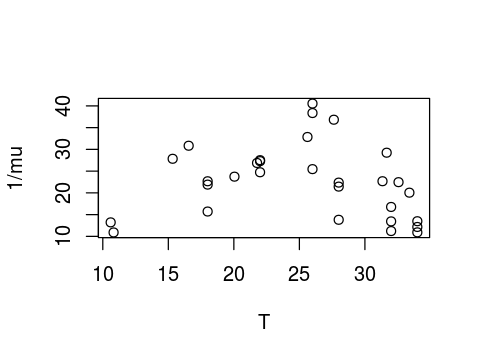

In [79]:
mu.data.inv <- mu.data # make a copy of the mu data
mu.data.inv$trait <- 1/mu.data$trait # take the inverse of the trait values to convert mu to lifespan
lf.data.comb <- rbind(mu.data.inv, lf.data) # combine both lifespan data sets together 
  
plot(trait ~ T, data = lf.data.comb, ylab="1/mu")

#### Two thermal performance curve models
Most thermal response curves can be reasonably fit using one of two thermal reponses. Traits that respond unimodally but symmetrically to temperature can be fit with a quadratic function:

$ B = q (T-T_0) (T-T_m)$  

Traits that respond unimodally but asymetrically can be fited with a Briere function:

$B = q T (T-T_0) \sqrt{T_m-T}$

In both models, $T_0$ is the lower thermal limit, $T_m$ is the upper thermal limit (i.e., where the trait value goes to zero on either end), and $q$ scales the elevation of the curve, (and so also the value at the optimum temperature).   


#### The thermal response model file
Unlike the previous bayesian \example, here we will provide jags with the model written as a `.txt` file. THis can be in your working directory, or elsewhere (but then inout the full path to it --- ideally a relative path). 

You can either write the text yourself directly to the file, or create it using the sink() function via your R script (see below):

Note that the model file `quad.txt` has two mandatory sections (the priors and the likelihood) and one optional section (derived measures calculated from your fitted parameters).

In the example below for a quadratic function, most of the priors are specified via uniform distributions (the two arguments specific the lower and upper bounds, respectively). Note that unlike in R and most other programs, in jags, the inverse of the variance of the normal distribution is used, denoted by $\tau (= \frac{1}{\sigma^2}$).  

The likelihood for can be interpreted as follows: the observed data are normally distributed where the mean at a given temperature follows the quadratic equation.

Now, prepare the data for jags: 

In [80]:
# Parameters to Estimate
parameters <- c("cf.q", "cf.T0", "cf.Tm","cf.sigma", "z.trait.mu.pred")

# Initial values for the parameters
inits<-function(){list(
  cf.q = 0.01,
  cf.Tm = 35,
  cf.T0 = 5,
  cf.sigma = rlnorm(1))}

# MCMC Settings: number of posterior dist elements = [(ni - nb) / nt ] * nc
ni <- 25000 # number of iterations in each chain
nb <- 5000 # number of 'burn in' iterations to discard
nt <- 8 # thinning rate - jags saves every nt iterations in each chain
nc <- 3 # number of chains

# Temperature sequence for derived quantity calculations
Temp.xs <- seq(0, 45, 0.2)
N.Temp.xs <-length(Temp.xs)

### Fitting the trait thermal response; Pull out data columns as vectors
data <- lf.data.comb # this lets us reuse the same generic code: we only change this first line
trait <- data$trait
N.obs <- length(trait)
temp <- data$T

# Bundle all data in a list for JAGS
jag.data<-list(trait = trait, N.obs = N.obs, temp = temp, Temp.xs = Temp.xs, N.Temp.xs = N.Temp.xs)

Now run the fitting using jags:

In [81]:
lf.fit <- jags(data=jag.data, inits=inits, parameters.to.save=parameters, 
               model.file="quad.txt", n.thin=nt, n.chains=nc, n.burnin=nb, 
               n.iter=ni, DIC=T, working.directory=getwd())

ERROR: Error in jags(data = jag.data, inits = inits, parameters.to.save = parameters, : could not find function "jags"


Change into "mcmc" type samples for visualization with the `coda` package:

In [82]:
lf.fit.mcmc <- as.mcmc(lf.fit)

ERROR: Error in as.mcmc(lf.fit): object 'lf.fit' not found


#### Running diagnostics

View the parameters (only the first 5 lines, or it will also show you all of your derived quantities):

In [83]:
lf.fit$BUGSoutput$summary[1:5,]

ERROR: Error in eval(expr, envir, enclos): object 'lf.fit' not found


Plot the chains:

In [84]:
plot(lf.fit.mcmc[,c(1,3,4)])

ERROR: Error in plot(lf.fit.mcmc[, c(1, 3, 4)]): object 'lf.fit.mcmc' not found


#### Plot the fits

ERROR: Error in eval(predvars, data, env): object 'lf.fit' not found


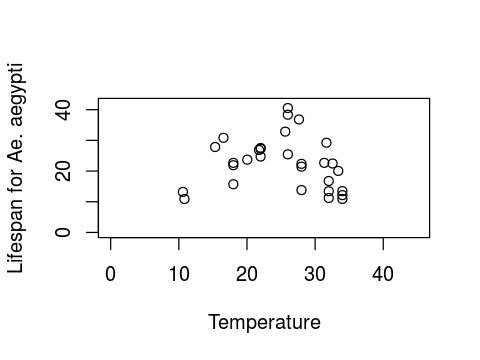

In [85]:
plot(trait ~ T, xlim = c(0, 45), ylim = c(0,42), data = lf.data.comb, ylab = "Lifespan for Ae. aegypti", xlab = "Temperature")
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "2.5%"] ~ Temp.xs, lty = 2)
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "97.5%"] ~ Temp.xs, lty = 2)
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"] ~ Temp.xs)

#### Additional analyses

You can use the `which.max()` function to find the optimal temperature for adult lifespan:

In [86]:
Temp.xs[which.max(as.vector(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"]))]

ERROR: Error in as.vector(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"]): object 'lf.fit' not found


You can also pull out the lifespan values for each iteration of the MCMC chain over the temperature gradient to calculate $R_0$:

In [87]:
lf.grad <- lf.fit$BUGSoutput$sims.list$z.trait.mu.pred
dim(lf.grad) # A matrix with 7500 iterations of the MCMC chains at 226 temperatures

ERROR: Error in eval(expr, envir, enclos): object 'lf.fit' not found


### A Bayesian model fitting of abundance data

We will now perform a bayesian analysis of population growth data.   

In [88]:
require(R2jags) # does the fitting
require(coda) # makes diagnostic plots
library(IDPmisc) # makes nice colored pairs plots to look at joint posteriors

Loading required package: R2jags
Loading required package: rjags
Error: package or namespace load failed for ‘rjags’:
 .onLoad failed in loadNamespace() for 'rjags', details:
  call: load.module("basemod", quiet = TRUE)
  error: File not found: /usr/lib/JAGS/modules-4/basemod.so
Loading required package: grid
Loading required package: lattice


#### The Data

These data are observations of the amphibian fungal pathogen  _Batrachochytrium dendrobatidis_ being grown in liquid culture at multiple different temperatures. The experiment is conducted in 96 well plates with a fixed initial innoculation of fungal spores in each well, and the plate placed in a constant temperature incubator. Each day, 8 wells per plate are observed and the optical density (OD) is measured. We will focus on a single temperature trial across mulitple plates with OD as the response. 

We will fit a logistic model to these growth data. 

Let's have a look at the data first:

In [89]:
dat <- read.csv("../data/lb_ab_temps.csv")
head(dat)

X,EXP,TEMP,DAY,ISOLATE,PLATE,WELL,OD,NC_AVG,OD_SUB
1,2,5,1,LB_AB,P.16,1,0.120,0.1195,0.0005
2,2,5,1,LB_AB,P.16,2,0.120,0.1195,0.0005
3,2,5,1,LB_AB,P.16,3,0.122,0.1195,0.0025
4,2,5,1,LB_AB,P.16,4,0.123,0.1195,0.0035
5,2,5,1,LB_AB,P.16,5,0.125,0.1195,0.0055
6,2,5,1,LB_AB,P.16,6,0.125,0.1195,0.0055


We are only interested in a subset of these data, so we will subset out only those from experiment 2, and a temperature of 12$^\circ$C.

In [90]:
d2<-dat[which(dat$EXP==2),2:8]
d2<-d2[which(d2$TEMP==12),]
summary(d2)

      EXP         TEMP         DAY         ISOLATE        PLATE    
 Min.   :2   Min.   :12   Min.   : 1.00   LB_AB:730   P.11   :160  
 1st Qu.:2   1st Qu.:12   1st Qu.: 9.00               P.12   :150  
 Median :2   Median :12   Median :19.00               P.13   :150  
 Mean   :2   Mean   :12   Mean   :19.04               P.14   :140  
 3rd Qu.:2   3rd Qu.:12   3rd Qu.:29.00               P.15   :130  
 Max.   :2   Max.   :12   Max.   :39.00               P.1    :  0  
                                                      (Other):  0  
      WELL             OD        
 Min.   :1.000   Min.   :0.0930  
 1st Qu.:2.000   1st Qu.:0.1630  
 Median :4.000   Median :0.2580  
 Mean   :4.315   Mean   :0.2437  
 3rd Qu.:6.000   3rd Qu.:0.3170  
 Max.   :8.000   Max.   :0.4600  
                                 

Now plot it:

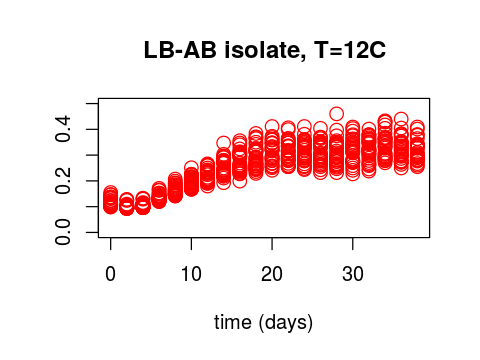

In [91]:
Temps<-seq(0,max(d2$DAY)-1, by=0.05)
mycol<-1   
my.ylim<-c(0, 0.5)
my.title<-"LB-AB isolate, T=12C"

plot(d2$DAY-1, d2$OD, xlim=c(0,max(Temps)), ylim=my.ylim,
    pch=(mycol+20),
    xlab="time (days)", ylab="",
    main=my.title,
    col=mycol+1, cex=1.5)

#### Specifying the growth curve

Although logistic growth is often written as a differential equation, here we will work with the analytic solution of the model:

$$
\mu(t) = \frac{KY_0}{Y_0+(K-Y_0)\exp{(-rt)}}
$$

This gives the mean function that we want to fit. We will assume log-normal noise around this response, as the optical density is bounded to be greater than 0 and since we also have increasing variance over time (as the optical density increases).


#### The thermal response model file

JAGS needs the model written as a `.txt` or `.bug` file inside the working directory. You can either make the text file directly, or create it using the `sink()` function in your R script, as follows:  

Note that the model file has two mandatory sections (the priors and the likelihood) and one optional section (derived quantiaties calculated from your fitted parameters).  

In the example below we will build the model function with the log-normal likelihood for the logistic growth function. Priors are a combination of uniform and exponential distributions. As with the normal distribution, jags uses $\tau$ to parameterize the variance of the normal distribution ($\tau = 1/(\sigma^2)$). However it can be easier to specify the prior on sigma directly. In this example we will generate posterior samples of derived quantities outside of JAGS (so you can see what this is actually doing).


#### Additional settings for jags 

Now for some additional settings/specifications for jags:

In [92]:
# Parameters to Estimate
parameters <- c('Y0', 'K', 'r', 'sigma')

# Initial values for the parameters
inits<-function(){list(
  Y0 = 0.1,
  K = 0.4,
  r = 0.1,
  sigma = rlnorm(1))}

# MCMC Settings: number of posterior dist elements = [(ni - nb) / nt ] * nc
ni <- 6000 # number of iterations in each chain
nb <- 1000 # number of 'burn in' iterations to discard
nt <- 1 # thinning rate - jags saves every nt iterations in each chain
nc <- 5 # number of chains

#### Fitting the model

Now we can run jags:

In [93]:
# Pull out data columns as vectors
data <- d2 # this lets us reuse the same generic code: we only change this first line
Y <- data$OD
N <- length(Y)
t <- data$DAY

# Bundle all data in a list for JAGS
jag.data<-list(Y = Y, N = N, t = t)

# Run JAGS
OD.12C <- jags(data=jag.data, inits=inits, parameters.to.save=parameters, 
               model.file="jags-logistic.bug", n.thin=nt, n.chains=nc, n.burnin=nb, 
               n.iter=ni, DIC=T, working.directory=getwd())

ERROR: Error in jags(data = jag.data, inits = inits, parameters.to.save = parameters, : could not find function "jags"


Change into "mcmc" type samples for visualization with `coda`:

In [94]:
OD.12C.mcmc<-as.mcmc(OD.12C)

ERROR: Error in as.mcmc(OD.12C): object 'OD.12C' not found


#### Diagnostics

As you did in the [Traits bayesian fitting example](#Aedes-data-revisited-using-Bayesian-fitting), there are a number of model diagnostics that we need to check. First we want to look at the chains and confirm that they look like "fuzzy caterpillars" -- no linear/non-linear patterns across the chains, low auto-correlation, etc.

First view the fitted parameters:

In [95]:
OD.12C$BUGSoutput$summary

ERROR: Error in eval(expr, envir, enclos): object 'OD.12C' not found


Plot the chains using the coda package:

In [96]:
plot(OD.12C.mcmc[,c(1,2,4)])

ERROR: Error in plot(OD.12C.mcmc[, c(1, 2, 4)]): object 'OD.12C.mcmc' not found


We can examine the ACF of the chains as well, similarly to a time series:

In [97]:
s1<-as.data.frame(OD.12C.mcmc[[1]])
par(mfrow=c(2,2))
for(i in 2:5) acf(s1[,i], lag.max=20)

ERROR: Error in as.data.frame(OD.12C.mcmc[[1]]): object 'OD.12C.mcmc' not found


There is still a bit of autocorrelation, but it isn't too bad. The chain for $\sigma$ is mixing best. We could reduce the autocorrelation even further by thinning the chain (i.e., change the `nt` parameter to 5 or 10).

The last important diagnostic is to compare the prior and posterior distributions. Various packages in R have bespoke functions to do this. Here we use functions that we provide in the `mcmc_utils.R` file provided on the website.

In [98]:
source("../code/mcmc_utils.R")

ERROR: Error: package or namespace load failed for ‘rjags’:
 .onLoad failed in loadNamespace() for 'rjags', details:
  call: load.module("basemod", quiet = TRUE)
  error: File not found: /usr/lib/JAGS/modules-4/basemod.so


We also can write a function to put the samples into a convenient format for visualizing, etc:

In [99]:
samps<-NULL
for(i in 1:nc){
  samps<-rbind(samps, as.data.frame(OD.12C.mcmc[[i]]))
}

samps<-samps[,c(5,2,3,4)]

ERROR: Error in as.data.frame(OD.12C.mcmc[[i]]): object 'OD.12C.mcmc' not found


And also, we can building a list to hold all the information about the priors for each parameter:

In [100]:
priors<-list()
priors$names<-c("Y0", "K", "r","sigma")
priors$fun<-c("uniform", "uniform", "exp","exp")
priors$hyper<-matrix(NA, ncol=4, nrow=3)
priors$hyper[,1]<-c(0.09, 0.15, NA)
priors$hyper[,2]<-c(0.01,  0.6, NA)
priors$hyper[,3]<-c(1000, NA, NA) 
priors$hyper[,4]<-c(0.1, NA, NA)

Now we can plot the histograms of the posterior samples together with the prior distributions:

In [101]:
plot.hists(samps, my.par=c(2,2), n.hists=4, priors=priors, mai=c(0.5, 0.5, 0.25, 0.2))

ERROR: Error in plot.hists(samps, my.par = c(2, 2), n.hists = 4, priors = priors, : could not find function "plot.hists"


The prior distribution here is very different from the posterior. These data are highly informative for the parameters of interest and are very unlikely to be influenced much by the prior distribution (although you can always change the priors to check this). However, notice that $Y_0$ (the initial condition) is truncated by the prior. This is a fairly strong prior, because we know something about the initial optical density that is typical for the esperimental set up with the density of innoculum used and with a properly calibrated set-up.

#### Visualizing the joint posterior of parameters 

It's often useful to also look at the joint distbution of all of your parameters together. Of course, if you have a high dimensional posterior, rendering a 2-D representation can be difficult. Instead, the standard is to examine the pair-wise posterior distribution, for instance as follows (using the `s1` data frame we created above):

In [102]:
ipairs(s1[,2:5], ztransf = function(x){x[x<1] <- 1; log2(x)})

ERROR: Error in is.data.frame(x): object 's1' not found


As you can see, estimates of $r$ and $K$ are highly correlated -- not surprising given the interplay between them in the logistic growth function. This correlation is an important feature of the system, and we use the full posterior distribution that includes this correlation when we want to build the corresponding posterior distribution of the behavior of the logistic function.

#### The posterior distribution of the mean function

The final step is to check how well we are fitting the data. To do this we usually examine the posterior distribution of the mean function of our system, in this case the distribution of the logistic solution and compare this to the data. To do this, for each of our posterior samples (or a thinned subset), we plug the parameters for the $i^{\mathrm th}$ sample $\theta_i$ into our function of interest, and evaluate the function as a desired set of $x$'s. For instance, for logistic growth, we'll evaluate 
$$
\mu(t) = \frac{K_iY_{0,i}}{Y_{0,i}+(K_i-Y_{0,i})\exp{(-r_it)}}
$$
for the $i^{\mathrm th}$ set of parameters for a sequence of times, $t$. This we obtain points describing the curve $\mu_i(t)$ for each set of parameters. Here is one way to do this:

In [103]:
my.logistic<-function(t, Y0, K, r){
  return(K*Y0/(Y0+(K-Y0)*exp(-r*t)))
}

ts<-seq(0, 40, length=100)
ss<-seq(1, dim(samps)[1], by=10)
my.curves<-matrix(NA, nrow=length(ss), ncol=length(ts))

for(i in 1:length(ss)){
  my.curves[i,]<-my.logistic(t=ts, Y0=samps$Y0[i], K=samps$K[i], r=samps$r[i])
}

ERROR: Error in seq.default(1, dim(samps)[1], by = 10): 'to' must be of length 1


We can now plot all of these curves:

In [104]:
plot(ts, my.curves[1,], col=1, type="l", ylim=c(0.09, 0.36), 
     ylab="predicted OD", xlab="time (days)")
for(i in 2:length(ss)) lines(ts, my.curves[i,], col=i)

ERROR: Error in plot(ts, my.curves[1, ], col = 1, type = "l", ylim = c(0.09, : object 'my.curves' not found


Then we can summarize this posterior using the `apply` function to find the mean and the (for simplicity) quantile based 95% CI:

In [105]:
m.log<-apply(my.curves, 2, mean)
l.log<-apply(my.curves, 2, quantile, probs=0.025)
u.log<-apply(my.curves, 2, quantile, probs=0.975)

ERROR: Error in apply(my.curves, 2, mean): object 'my.curves' not found


For comparison, here is how to find the 95% HPD Interval across time, using the `HPDinterval` function from the `coda` package:

In [106]:
hpd.log<-NULL
for(i in 1:length(ts)){
  hpd.log<-cbind(hpd.log, as.numeric(HPDinterval(mcmc(my.curves[,i]))))
}

ERROR: Error in mcmc(my.curves[, i]): object 'my.curves' not found


And plot these together with the data (in this case the HPD and quantile based intervals are indistinguishable):

ERROR: Error in xy.coords(x, y): object 'm.log' not found


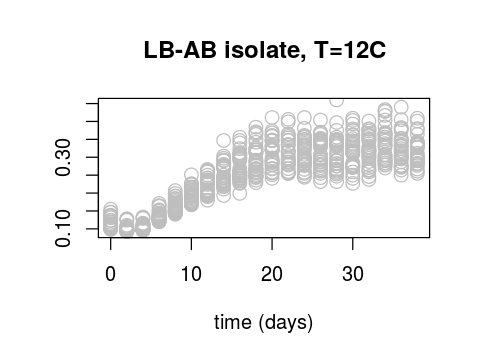

In [107]:
my.ylim<-c(0.09, 0.45)
my.title<-"LB-AB isolate, T=12C"

plot(d2$DAY-1, d2$OD, xlim=c(0,max(Temps)), ylim=my.ylim,
    pch=(mycol+20),
    xlab="time (days)", ylab="",
    main=my.title,
    col="grey", cex=1.5)
lines(ts, m.log, col=1, lwd=2)
lines(ts, l.log, col=2, lwd=2, lty=2)
lines(ts, u.log, col=2, lwd=2, lty=2)

lines(ts, hpd.log[1,], col=3, lwd=2, lty=3)
lines(ts, hpd.log[2,], col=3, lwd=2, lty=3)

Note that this only shows the uncertainty in the *mean function* -- the assumed model with log normal noise says that the observations simply have this mean. The fit is attributing the majority of the observed noise to process error rather than parameter uncertainty.

Readings and Resources <a id='Readings'></a>
--------------------------------------------
* Motulsky, Harvey, and Arthur Christopoulos. Fitting models to biological data using linear and nonlinear regression: a practical guide to curve fitting. OUP USA, 2004.
* Johnson, J. B. & Omland, K. S. 2004 Model selection in ecology and evolution. Trends Ecol. Evol. 19, 101–108.
* The [NCEAS non-linear modelling working group](https://groups.nceas.ucsb.edu/non-linear-modeling/projects/OrangeTree)
* [Mixed-Effects Models in S and S-PLUS](https://link.springer.com/book/10.1007/b98882)
* Bolker, B. Ecological models and data in R. (Princeton University Press, 2008). 